# Effect of COVID travel restrictions on Sydney Airbnb listings 
## Scraped data available from "Inside Airbnb" site 
(http://insideairbnb.com/get-the-data.html)
### Some questions  
- How have the travel restrictions resulting from border closures impacted the listings, bookings, and occupancy of Airbnb listings in Sydney?
 - Have the number of listings changed?
 - Have the prices of listings changed?
 - Has occupancy decreased?
 - Have bookings decreased?
 - Has the makeup of the listings changed?
 - Have the factors correlated with price changed?

### Methodology
#### Available data
The data availiable for Sydney from the 'Inside Airbnb' site was scraped monthly between **11 June 2020** and **10 April 2021**. (Note - There is a dead link to a file for May 2020.)
Three types of csv files are availiable - *listings*, *calendar*, and *reviews*. The *listings* file contains the all the information regarding the characteristics of each listing, including forward availability for the next year that has been distilled from the *calendar* file and the numbers of reviews from the *reviews* file.

The *listings* files contain between 74 and 106 features for 33,000 to 37,000 listings. Approximately 72 features were common to all *listings* files. 

#### Occupancy
Data for occupancy levels for each listing would be extremely useful data, however, this is not availiable to be scraped from the Airbnb site. Occupancy has been estimated previously in analyses on the "Inside Airbnb" site using the number of reviews as a proxy by assuming that the number of reviews is proportional to occupancy. Number of reviews will be used here as proxy for occupancy also, but in a comparative fashion where a  constant of proprtionality is not necessary. 

#### Files used
Comparisons were initially made between the data for earliest month, June'20, and the latest month, April '21. Data for the months in between was also used to provide support for any identified trends since any effects due to COVID would be expected to present as a gradient over this time period as the COVID impacts an increasingly larger portion of the data period.
#### Feature engineering
Additional information was extracted from some features for the modelling component .......
#### Mapping the chronology of travel restictions into and within Australia
#### Use of availability and number of reviews

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math
import re
import matplotlib.dates as mdates
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib inline

## Load files 
Initially load the earliest and latest available files, ie. June 2020 and April 2021. 

In [2]:
listings_orig_20 = pd.read_csv(r'C:\Users\z2216895\OneDrive - UNSW\Documents\General\Udacity\Data Scientist\Project-1\Sydney AirBnB\listings_20.csv')
listings_orig_21 = pd.read_csv(r'C:\Users\z2216895\OneDrive - UNSW\Documents\General\Udacity\Data Scientist\Project-1\Sydney AirBnB\listings.csv', low_memory=False)

C:\Users\z2216895\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (43,61,62,94) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# Create working files 
listings_20 = listings_orig_20.copy()
listings_21 = listings_orig_21.copy()

## Initial look at files
### Columns

In [4]:
# Numbers of rows and columns in files 
print('listings_20 file has {} rows and {} columns'.format(listings_20.shape[0], listings_20.shape[1]))
print('listings_21 file has {} rows and {} columns'.format(listings_21.shape[0], listings_21.shape[1]))

listings_20 file has 36901 rows and 106 columns
listings_21 file has 32679 rows and 74 columns


The listings_20 file has 32 more features than the listings_21 file. The common features will be identified and the files harmonized in order to faciliate useful comparisons

In [5]:
# Identify how many columns are common to both files 
num_of_common_columns = listings_20.columns.isin(listings_21.columns).sum()
print('There are {} colmuns common to both files'.format(num_of_common_columns))

There are 72 colmuns common to both files


So, only 2 columns from the listings_21 file are not in the listings_20 file.

In [6]:
# The 2 columns from the listings_21 file are not in the listings_20 file 
print('The columns from the listings_21 file that are not in the listings_20 file are')
listings_21.columns[~listings_21.columns.isin(listings_20.columns)].tolist()

The columns from the listings_21 file that are not in the listings_20 file are


['bathrooms_text', 'number_of_reviews_l30d']

Features with information regarding bathrooms may be useful so these are investigated in both files. The number of reviews for the last 30 days might have been useful. The columns with information on the number of reviews will also be investigated.
### Bathroom features

In [7]:
# Find features about bathrooms in files
s_20 = listings_20.columns[listings_20.columns.str.contains('bath')]
s_21 = listings_21.columns[listings_21.columns.str.contains('bath')]
for b in s_20:
    print('listings_20 file contains {}'.format(b))
print()
for b in s_21:
    print('listings_21 file contains {}'.format(b))

listings_20 file contains bathrooms

listings_21 file contains bathrooms
listings_21 file contains bathrooms_text


In [8]:
# Look at the bathroom features
pd.DataFrame([listings_20.bathrooms, listings_21.bathrooms, listings_21.bathrooms_text]).T.head()

,bathrooms,bathrooms,bathrooms_text
0,1,NaN,1 shared bath
1,1,NaN,1 shared bath
2,3,NaN,3 baths
3,1,NaN,1 private bath
4,1,NaN,1 bath


It looks like listings_21.bathrooms contains no useful information while listings_20.bathrooms contains the number of bathrooms but does identify the type of bathroom as in listing_21.bathrooms_text. listings_21.bathrooms_text will be converted to a number and renamed. 

In [9]:
# Convert listings_21.bathrooms_text to number and rename as listings_21.bathrooms

# Create new series as a copy of listings.bathrooms_text
bathrooms = listings_21.bathrooms_text.copy() 

# Create an index containing the index values for entries containg a number
idx = bathrooms[bathrooms.str.contains('\d').astype('boolean')].index

# Extract the float number from the entries with index in idx
temp = pd.Series([float(re.findall(r'[\d\.\d]+', bathrooms[n])[0]) for n in idx],
                     index = idx, name = 'num_baths')
# Replace the entries with an index in idx with a float number
for n in idx:
    bathrooms[n] = temp[n].copy()
    
bathrooms.value_counts()

1.0                  22711
2.0                   4939
1.5                   2061
3.0                   1059
2.5                    996
3.5                    269
4.0                    223
0.0                    139
4.5                     59
5.0                     46
Shared half-bath        39
6.0                     32
Half-bath               31
5.5                     17
18.0                    11
Private half-bath        5
6.5                      4
7.0                      3
8.0                      2
15.0                     1
10.0                     1
14.5                     1
Name: bathrooms_text, dtype: int64

In [10]:
#Convert half-baths to number 0.5
idx = bathrooms[bathrooms.str.contains('half', case=False).astype('boolean')].index
for n in idx:
    bathrooms[n] = 0.5
bathrooms = bathrooms.astype(float)
bathrooms.value_counts()

1.0     22711
2.0      4939
1.5      2061
3.0      1059
2.5       996
3.5       269
4.0       223
0.0       139
0.5        75
4.5        59
5.0        46
6.0        32
5.5        17
18.0       11
6.5         4
7.0         3
8.0         2
15.0        1
10.0        1
14.5        1
Name: bathrooms_text, dtype: int64

Replace listings_21.bathrooms with new bathrooms number values and remove listings.bathrooms_text

In [11]:
listings_21.bathrooms = bathrooms
listings_21.drop('bathrooms_text', axis=1, inplace=True)

In [12]:
listings_21.columns[listings_21.columns.str.contains('bath')].tolist()

['bathrooms']

In [13]:
listings_21.bathrooms.dtype

dtype('float64')

### Number of reviews features

In [14]:
# Find features relating to reviews in files
s_20 = listings_20.columns[listings_20.columns.str.contains('review')]
s_21 = listings_21.columns[listings_21.columns.str.contains('review')]
for b in s_20:
    print('listings_20 file contains {}'.format(b))
print()
for b in s_21:
    print('listings_21 file contains {}'.format(b))

listings_20 file contains number_of_reviews
listings_20 file contains number_of_reviews_ltm
listings_20 file contains first_review
listings_20 file contains last_review
listings_20 file contains review_scores_rating
listings_20 file contains review_scores_accuracy
listings_20 file contains review_scores_cleanliness
listings_20 file contains review_scores_checkin
listings_20 file contains review_scores_communication
listings_20 file contains review_scores_location
listings_20 file contains review_scores_value
listings_20 file contains reviews_per_month

listings_21 file contains number_of_reviews
listings_21 file contains number_of_reviews_ltm
listings_21 file contains number_of_reviews_l30d
listings_21 file contains first_review
listings_21 file contains last_review
listings_21 file contains review_scores_rating
listings_21 file contains review_scores_accuracy
listings_21 file contains review_scores_cleanliness
listings_21 file contains review_scores_checkin
listings_21 file contains r

The feature regarding the number of reviews in the last 12 months ('number_of_reviews_ltm') looks to be the most useful. 'number_of_reviews_l30d' is removed since it is only in the listings_21 file.

In [15]:
listings_21.drop('number_of_reviews_l30d', axis=1, inplace=True)
listings_21.shape

(32679, 72)

### Harmonizing columns
listings_21 now has the the target of 72 columns that are common with listings_20. The unmatched columns of listings_20 are removed.

In [16]:
listings_20.shape

(36901, 106)

In [17]:
# Identify the 34 columns to remove from listings_20
cols_to_remove = listings_20.columns[~listings_20.columns.isin(listings_21.columns)]
print('{} columns to remove from listings_20'.format(cols_to_remove.shape[0]))
cols_to_remove

34 columns to remove from listings_20


Index(['summary', 'space', 'experiences_offered', 'notes', 'transit', 'access',
       'interaction', 'house_rules', 'thumbnail_url', 'medium_url',
       'xl_picture_url', 'street', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'is_location_exact',
       'bed_type', 'square_feet', 'weekly_price', 'monthly_price',
       'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people',
       'requires_license', 'jurisdiction_names', 'is_business_travel_ready',
       'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification'],
      dtype='object')

In [18]:
# Remove colomns from listings_20
listings_20.drop(cols_to_remove, axis=1, inplace=True)
listings_20.shape

(36901, 72)

### Datatypes

In [19]:
listings_20.dtypes.value_counts()

object     34
int64      20
float64    18
dtype: int64

In [20]:
listings_21.dtypes.value_counts()

object     32
int64      20
float64    20
dtype: int64

The two files do not have identical dtypes despite having the same column labels. There are two 'object' columns in listings_20 that are 'float64' in listings_21. Let's investigate further.

In [21]:
flt_21 = listings_21.dtypes[listings_21.dtypes == 'float64'].index
flt_20 = listings_20.dtypes[listings_20.dtypes == 'float64'].index
idx_flt = flt_21[~flt_21.isin(flt_20)]
idx_flt

Index(['calendar_updated', 'license'], dtype='object')

In [22]:
listings_20[idx_flt.tolist()].head()

,calendar_updated,license
0,3 months ago,NaN
1,7 months ago,NaN
2,2 months ago,NaN
3,6 months ago,NaN
4,5 weeks ago,NaN


In [23]:
listings_21[idx_flt.tolist()].head()

,calendar_updated,license
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN


These two features are not useful since both are NaN in listings_21. Therefore will remove.

In [24]:
listings_20.drop(idx_flt, axis=1, inplace=True)
listings_21.drop(idx_flt, axis=1, inplace=True)

In [25]:
print('listings_20 has {} columns'.format(listings_20.shape[1]))
print('listings_21 has {} columns'.format(listings_21.shape[1]))

listings_20 has 70 columns
listings_21 has 70 columns


Some 'object' columns may need to be converted to a 'number' dtype. Some of the columns may also be expressed as 'boolean' and 'date' dtypes, however, 'number' dtypes will be considered initially.

In [26]:
# Check that all 'object' columns are identical between the files
listings_20.dtypes[listings_20.dtypes == 'object'].isin(listings_21.dtypes[listings_21.dtypes == 'object']).sum()

32

In [27]:
#Example of listing that has all entries of 'object' dtype populated
listings_20[listings_20.dtypes[listings_20.dtypes == 'object'].index].iloc[100]

listing_url                             https://www.airbnb.com/rooms/366856
last_scraped                                                     2020-06-11
name                                     Bondi Studio - FAB DECOR AND STYLE
description               Our fabulous  Studio provides a beautiful spac...
neighborhood_overview     Situated amongst the some of the best restaura...
picture_url               https://a0.muscache.com/im/pictures/4115929/7f...
host_url                          https://www.airbnb.com/users/show/1852102
host_name                                                       Ann And Mad
host_since                                                       2012-03-03
host_location                             Bondi, New South Wales, Australia
host_about                As Bondi locals, we love our beachside communi...
host_response_time                                           within an hour
host_response_rate                                                     100%
host_accepta

There is one column, 'price', that has a '$' sign and two columns, 'host_response_rate' and 'host_acceptance_rate', that contain a '%' sign. There are also date columns whose string starts with '20' and boolean columns that contain 't' or 'f'.

Remove '$' and '% signs from thses columns an convert to a 'number' dtype.

In [28]:
# Remove '$' character and convert to integer
listings_20.price = listings_20.price.replace('[\$,]', '',regex=True).astype(float).astype('Int64')
listings_21.price = listings_21.price.replace('[\$,]', '',regex=True).astype(float).astype('Int64')

In [29]:
listings_20.price.dtype

Int64Dtype()

In [30]:
# Remove '%' character and convert to integer
for col in ['host_response_rate','host_acceptance_rate']:
    listings_20[col] = listings_20[col].str.replace('%', '').astype(float).astype('Int64')
    listings_21[col] = listings_21[col].str.replace('%', '').astype(float).astype('Int64')
listings_20[['host_response_rate','host_acceptance_rate']].dtypes

host_response_rate      Int64
host_acceptance_rate    Int64
dtype: object

## Mapping the chronology of Australian travel restrictions
Data describing the timeline of travel restrictions was obtained from a report by the Grattan Institute entitled 'Australia’s COVID-19 response: the story so far' (https://grattan.edu.au/news/australias-covid-19-response-the-story-so-far/).

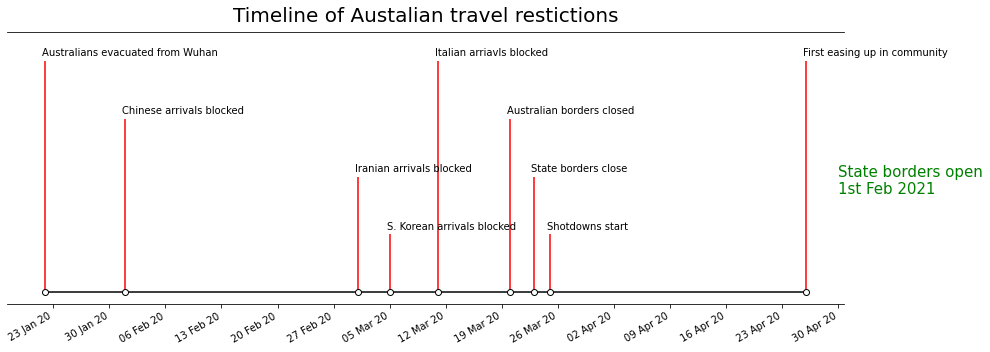

In [31]:
dates=['2020-01-22', '2020-02-01', '2020-03-01', '2020-03-05', '2020-03-11', '2020-03-20', '2020-03-23', 
       '2020-03-25', '2020-04-26']
names = ['Australians evacuated from Wuhan', 'Chinese arrivals blocked', 'Iranian arrivals blocked',
         'S. Korean arrivals blocked', 'Italian arriavls blocked', 'Australian borders closed',
         'State borders close', 'Shotdowns start', 'First easing up in community']

dates = [datetime.strptime(d, "%Y-%m-%d") for d in dates]

levels = np.tile([4, 3,2,1],
                 int(np.ceil(len(dates)/4)))[:len(dates)]

fig, ax = plt.subplots(figsize=(15, 5), constrained_layout=False)
ax.set_title("Timeline of Austalian travel restictions", pad=10, size=20, weight=20)

ax.vlines(dates, 0, levels, color="r")  # The vertical stems.
ax.plot(dates, np.zeros_like(dates), "-o",
        color="k", markerfacecolor="w")  # Baseline and markers on it.

# annotate lines
for d, l, r in zip(dates, levels, names):
    ax.annotate(r, xy=(d, l),
                xytext=(-3, 3), textcoords="offset points",
                horizontalalignment="left",
                verticalalignment="bottom")

ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right");

ax.set_ylim([-0.2,4.5])
ax.yaxis.set_visible(False)
ax.spines['left'].set_visible(False)
#ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

open_date = datetime.strptime('2020-04-30', "%Y-%m-%d")
ax.annotate('State borders open', xy=(open_date, 2), size=15, c='g')
ax.annotate('1st Feb 2021', xy=(open_date, 1.7), size=15, c='g');

The timeline of Australian border closures and travel restrictions can be overlain on the timeperiods of the scraped Airbnb data. Two important time periods that provide information pertaining to the activity of listings are associated with each of the monthly data files.
1. The availability for the year **following** the scraping date has been extracted from the calander of each listing (listings_20.availability_365d) and is expected to be determined to some extent by the number of bookings for the coming year. Other factors will obviously impact this metric since owners may block out varying portions of the year.
2. The number of reviews for the year **prior** to the scraping date can be assumed to proportional to the occupancy of that period, based on the simple notion that greater occupancy will result in a greater number of reviews. For the purposes of this comparison between different periods the constant of proportionality is not important.  

The following diagram shows that the year prior to the first scraping date was mostly free from the effects of travel restrictions while the year prior to the last scraping date was entirely coincidental with border closures. The year following the first scraping date was entirely affected by international border closures and mostly affected by state border closures, while the year following the last scrape date had prospects of being unaffected by state border closures (these will prove to be tenuous with further outbreaks of COVID variants and slow vaccination rates) but being affected by international border closures extending for an uncertain period and only opening slowly.  

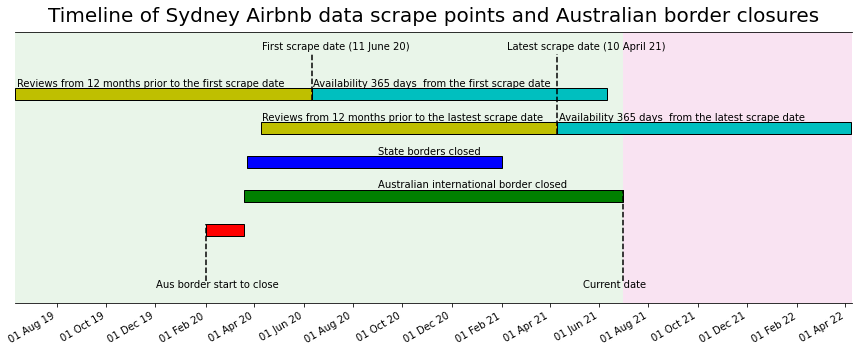

In [32]:
dates=['2020-01-22', '2020-02-01', '2020-03-01', '2020-03-05', '2020-03-11', '2020-03-20', '2020-03-23', 
       '2020-03-25', '2020-04-26']
dates = [datetime.strptime(d, "%Y-%m-%d") for d in dates]

xmin = datetime.strptime('2019-06-11', "%Y-%m-%d")
aus_start_border_close_date = datetime.strptime('2020-02-01', "%Y-%m-%d")
aus_border_all_close_date = datetime.strptime('2020-03-20', "%Y-%m-%d")
state_borders_close_date = datetime.strptime('2020-03-23', "%Y-%m-%d")
final_scrape_ltm_date = datetime.strptime('2020-04-10', "%Y-%m-%d")
first_scrape_date = datetime.strptime('2020-06-11', "%Y-%m-%d")
state_borders_open_date = datetime.strptime('2021-02-01', "%Y-%m-%d")
final_scrape_date = datetime.strptime('2021-04-10', "%Y-%m-%d")
first_scrape_date_plus1yr = datetime.strptime('2021-06-11', "%Y-%m-%d")
final_scrape_date_plus1yr = datetime.strptime('2022-04-10', "%Y-%m-%d")
current_date = datetime.strptime('2021-07-01', "%Y-%m-%d")
xmax = datetime.strptime('2022-04-10', "%Y-%m-%d")

span = xmax - xmin
delta_1 = aus_start_border_close_date - xmin
delta_2 = aus_border_all_close_date - xmin
delta_3 = state_borders_close_date - xmin
delta_4 = final_scrape_ltm_date -xmin
delta_5 = first_scrape_date - xmin
delta_6 = state_borders_open_date - xmin
delta_7 = final_scrape_date - xmin
delta_8 = first_scrape_date_plus1yr - xmin
delta_9 = final_scrape_date_plus1yr - xmin
delta_10 = current_date - xmin

aus_start_border_close_point = delta_1/span
aus_border_all_close_point = delta_2/span
state_borders_close_point = delta_3/span
final_scrape_ltm_point = delta_4/span
first_scrape_point = delta_5/span
state_borders_open_point = delta_6/span
final_scrape_point = delta_7/span
first_scrape_plus1yr_point = delta_8/span
final_scrape_plus1yr_point = delta_9/span
current_point = delta_10/span

fig, ax = plt.subplots(figsize=(15, 5), constrained_layout=False)
ax.set_ylim(0, 12)
ax.set_xlim(xmin, xmax)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
ax.yaxis.set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title("Timeline of Sydney Airbnb data scrape points and Australian border closures", pad=10, size=20, weight=20)

ax.axhspan(ymin=0, ymax=12, xmin=current_point, xmax=1, fc='tab:pink', alpha=0.2)
ax.axhspan(ymin=0, ymax=12, xmin=0, xmax=current_point, fc='tab:green', alpha=0.1)

ax.axhspan(ymin=3, ymax=3.5, xmin=aus_start_border_close_point, xmax=aus_border_all_close_point, fc='r', ec='k')
ax.axhspan(ymin=4.5, ymax=5, xmin=aus_border_all_close_point, xmax=current_point, fc='g', ec='k')
ax.axhspan(ymin=6, ymax=6.5, xmin=state_borders_close_point, xmax=state_borders_open_point, fc='b', ec='k')
ax.axhspan(ymin=7.5, ymax=8, xmin=final_scrape_ltm_point, xmax=final_scrape_point, fc='y', ec='k')
ax.axhspan(ymin=9, ymax=9.5, xmin=first_scrape_point, xmax=first_scrape_plus1yr_point, fc='c', ec='k')
ax.axhspan(ymin=7.5, ymax=8, xmin=final_scrape_point, xmax=0.998, fc='c', ec='k')
ax.axhspan(ymin=9, ymax=9.5, xmin=0, xmax=first_scrape_point, fc='y', ec='k')

ax.annotate('Australian international border closed', xy=(datetime(2020,9,1,0,0), 5.1))
ax.annotate('State borders closed', xy=(datetime(2020,9,1,0,0), 6.6))
ax.annotate('Reviews from 12 months prior to the lastest scrape date', xy=(datetime(2020,4,11,0,0), 8.1))
ax.annotate('Reviews from 12 months prior to the first scrape date', xy=(datetime(2019,6,13,0,0), 9.6))
ax.annotate('Availability 365 days  from the first scrape date', xy=(datetime(2020,6,13,0,0), 9.6))
ax.annotate('Availability 365 days  from the latest scrape date', xy=(datetime(2021,4,13,0,0), 8.1))

ax.vlines(aus_start_border_close_date, 1, 3.5, ls='dashed')
ax.vlines(final_scrape_date, 7.5, 11, ls='dashed')
ax.vlines(first_scrape_date, 9, 11, ls='dashed')
ax.vlines(current_date, 1, 5, ls='dashed')
ax.annotate('Aus border start to close', xy=(aus_start_border_close_date, 0.5), xytext=(-50, 5), textcoords="offset points")
ax.annotate('Latest scrape date (10 April 21)', xy=(final_scrape_date, 11), xytext=(-50, 5), textcoords="offset points")
ax.annotate('First scrape date (11 June 20)', xy=(first_scrape_date, 11), xytext=(-50, 5), textcoords="offset points")
ax.annotate('Current date', xy=(current_date, 0.5), xytext=(-40, 5), textcoords="offset points");

## Investigating the relationships between COVID travel restrictions and scraped data 
### Using the features regarding number of reviews ("number_of_reviews_ltm") and availability for the next year ("availability_365d")

The 'number_of_review_ltm' feature will be investigated initially since this feature shows the greatest apparent difference between the two scraping dates in impact from travel restrictions.  

#### Number of listings

The number of listings has decreased between June 2020 and April 2021. This suggests that the COVID travel restrictions have reduced activity on Airbnb. 

There was a 11.4% decrease in listings between June 2020 and April 2021


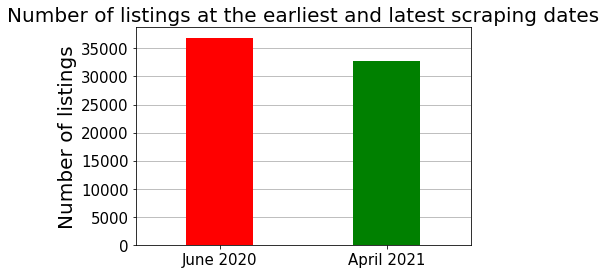

In [33]:
num_list_20 = listings_20.shape[0]
num_list_21 = listings_21.shape[0]
d = (num_list_20 - num_list_21)/num_list_20*100
print('There was a {:.1f}% decrease in listings between June 2020 and April 2021'.format(d))
plt.bar([0,1], [num_list_20, num_list_21], width=0.4, color=['r', 'g'], tick_label=['June 2020', 'April 2021'], zorder=2)
plt.grid(axis='y', zorder=1)
plt.xlim(-0.5,1.5)
plt.ylabel('Number of listings', size=20)
plt.title('Number of listings at the earliest and latest scraping dates', size=20)
plt.yticks(size=15)
plt.xticks(size=15);

#### Number of reviews for the previous year

In [34]:
# Check for missing values in the 'number_of_reviews_ltm' features
print('listings_20 has {} missing values'.format(listings_20.number_of_reviews_ltm.isna().sum()))
print('listings_21 has {} missing values'.format(listings_21.number_of_reviews_ltm.isna().sum()))

listings_20 has 0 missing values
listings_21 has 0 missing values


In [35]:
# Check for the proprtion of zero values
zero_20 = (listings_20.number_of_reviews_ltm == 0).sum()/listings_20.number_of_reviews_ltm.notna().sum()
zero_21 = (listings_20.number_of_reviews_ltm == 0).sum()/listings_21.number_of_reviews_ltm.notna().sum()
print('listings_20 has {:.2f} of all values as zero'.format(zero_20))
print('listings_21 has {:.2f} of all values as zero'.format(zero_21))

listings_20 has 0.56 of all values as zero
listings_21 has 0.63 of all values as zero


Most listings has no reviews from the previous year for both of scraping dates. These zero values represent either zero occupancy or some occupancy with no reviews submitted.  

The remaining non-zero values will be analysed.

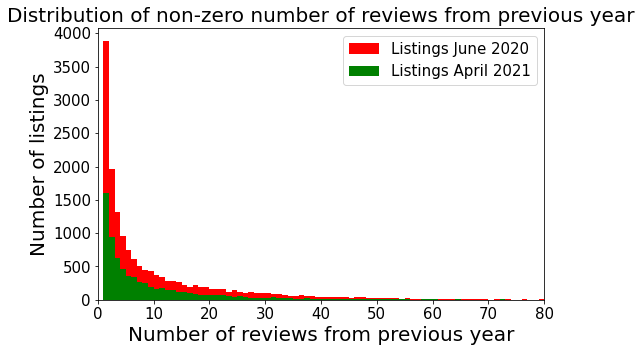

In [36]:
# Distribution of the non-zero number of reviews from the previous year for the earliest and latest data scraping dates
# **NOTE** - These plots are for NON-ZERO values
rev_20_ltm = listings_20.number_of_reviews_ltm[listings_20.number_of_reviews_ltm > 0]
rev_21_ltm = listings_21.number_of_reviews_ltm[listings_21.number_of_reviews_ltm > 0]
bins_20 = max(listings_20.number_of_reviews_ltm)
bins_21 = max(listings_21.number_of_reviews_ltm)
plt.figure(figsize=[8,5])
plt.hist(rev_20_ltm, bins=bins_20-1, color='r', label='Listings June 2020')
plt.hist(rev_21_ltm, bins=bins_21-1, color='g', label='Listings April 2021')
plt.xlim(0,80)
plt.legend(fontsize=15)
plt.ylabel('Number of listings', size=20)
plt.xlabel('Number of reviews from previous year', size=20)
plt.yticks(size=15)
plt.xticks(size=15)
plt.title('Distribution of non-zero number of reviews from previous year', size=20);

So clearly the number of reviews has decreased from the year previous to June 2020 to that previous to April 2021. The total number of reviews for all listings can calculated by summing all the reviews. 

In [37]:
sum_20 = listings_20.number_of_reviews_ltm.sum()
sum_21 = listings_21.number_of_reviews_ltm.sum()
print('For the year previous to June 2020 there were {} reviews for all listings'.format(sum_20))
print('For the year previous to April 2021 there were {} reviews for all listings'.format(sum_21))
print('Therefore, the total number of reviews decreased by {:.1f} times'.format(sum_20/sum_21))

For the year previous to June 2020 there were 167645 reviews for all listings
For the year previous to April 2021 there were 66965 reviews for all listings
Therefore, the total number of reviews decreased by 2.5 times


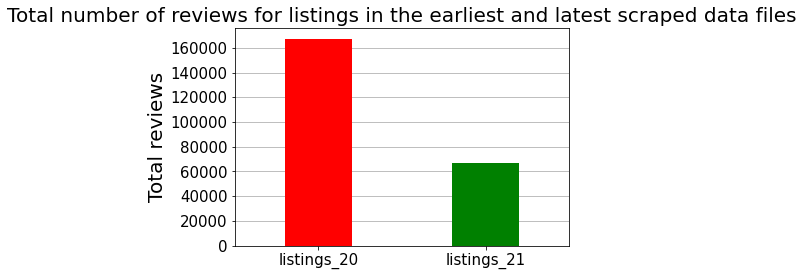

In [38]:
plt.bar([0,1], [sum_20, sum_21], width=0.4, color=['r', 'g'], tick_label=['listings_20', 'listings_21'], zorder=2)
plt.grid(axis='y', zorder=1)
plt.xlim(-0.5,1.5)
plt.ylabel('Total reviews', size=20)
plt.title('Total number of reviews for listings in the earliest and latest scraped data files', size=20)
plt.yticks(size=15)
plt.xticks(size=15);

This result suggests that the total numbers of nights occupied in Sydney listings during the year prior to the 10 April 2021, which coincided completly with travel restrictions, was less than half that of the year prior to 11 June 2020 which was only partially impacted by the restrictions.  

These data provide some insighth into the effect of the COVID travel restrictions on Airbnb activity in Sydney.

#### Availability for the following year
There are data for availability over 30, 60, 90, and 365 days following the scraped dates.

In [39]:
# Checking missing values
avail = ['availability_30', 'availability_60', 'availability_90', 'availability_365']
for a in avail:
    print('listings_20.{} has {} missing values'.format(a, listings_20[a].isna().sum()))
    print('listings_21.{} has {} missing values'.format(a, listings_21[a].isna().sum()))

listings_20.availability_30 has 0 missing values
listings_21.availability_30 has 0 missing values
listings_20.availability_60 has 0 missing values
listings_21.availability_60 has 0 missing values
listings_20.availability_90 has 0 missing values
listings_21.availability_90 has 0 missing values
listings_20.availability_365 has 0 missing values
listings_21.availability_365 has 0 missing values


(0.125, 0.5368181818181819, 0.35227272727272724, 0.34318181818181814)
(0.5477272727272726, 0.5368181818181819, 0.3522727272727273, 0.34318181818181814)
(0.125, 0.1250000000000001, 0.35227272727272724, 0.34318181818181814)
(0.5477272727272726, 0.1250000000000001, 0.3522727272727273, 0.34318181818181814)


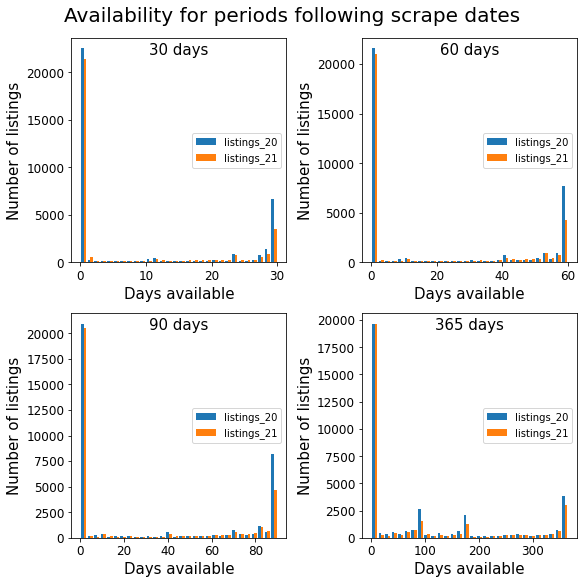

In [40]:
# Plot the availability for various periods following the the scraping dates
days = ['30', '60', '90', '365']
fig, axes = plt.subplots(2,2, figsize=[8,8], constrained_layout=True)
n = 0
for a in avail:
    r = n//2
    c = n%2
    axes[r,c].hist([listings_20[a], listings_21[a]], bins=30, label=['listings_20', 'listings_21'])
    axes[r,c].legend(loc=7)
    axes[r,c].set_title(days[n]+' days', size=15, y=0.9)
    axes[r,c].set_xlabel('Days available', size=15)
    axes[r,c].set_ylabel('Number of listings', size=15)
    axes[r,c].tick_params(labelsize=12)
    print(axes[r,c].get_position().bounds)
    n += 1
fig.suptitle('Availability for periods following scrape dates', size=20);



The distributions of the the number of days available for the various periods following the scrape date show very strong bimodal distrubtions for 30, 60, and 90 days. This can be summed up as either no days are availiable or all days are available. The distribution for 365 days shows a multimodal distribution with with additional peaks at 90 and 180 days, ie. 3 and 6 months.

The days available have clearly decreased from June 20 to April 21. The change in total days available is cacluated from the sums.

In [41]:
# Absolute comparison of available days
avail = ['availability_30', 'availability_60', 'availability_90', 'availability_365']
for a in avail:
    per_dec = (listings_20[a].sum() - listings_21[a].sum())/listings_20[a].sum()*100
    print('listings_20.{} available days has decreased by {:.1f}% '.format(a, per_dec))

listings_20.availability_30 available days has decreased by 30.5% 
listings_20.availability_60 available days has decreased by 28.4% 
listings_20.availability_90 available days has decreased by 27.0% 
listings_20.availability_365 available days has decreased by 21.9% 


This is an absolute comparsion. However, the decrease in total listings from June 2020 to April 2021 can be taken into account.

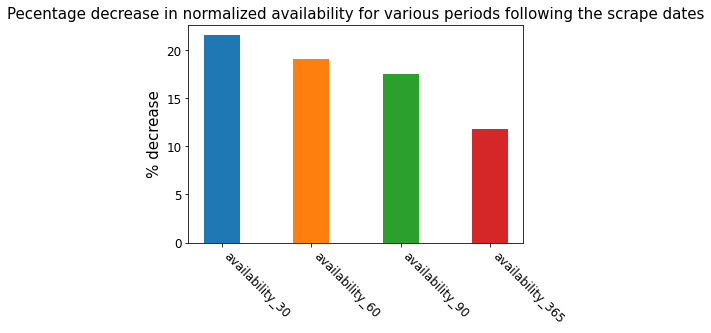

In [42]:
# Normalized comparison of available days
avail = ['availability_30', 'availability_60', 'availability_90', 'availability_365']
n = 1
for a in avail:
    av_norm_20 = listings_20[a].sum()/listings_20[a].shape[0]
    av_norm_21 = listings_21[a].sum()/listings_21[a].shape[0]
    per_dec_norm = (av_norm_20 - av_norm_21)/av_norm_20*100
    #print('Normalized listings_20.{} available days has decreased by {:.1f}% '.format(a, per_dec_norm))
    plt.bar(n, per_dec_norm, width=0.4, label=a)
    n += 1
#plt.legend()
plt.xticks(ticks=[1,2,3,4], labels=avail, size=12, rotation=-45, ha='left')
plt.yticks(size=12)
plt.ylabel('% decrease', size=15)
plt.title('Pecentage decrease in normalized availability for various periods following the scrape dates', size=15);

Therefore, the number of days available for the year following the scrape date per listing has decreased by about 12%.The shorter the period forward, the greater is the decrease.

This result implies that listings have less availability on average since either 1) listings have greater bookings or 2) a greater proportion of the year has been blocked out. 

Looking at the previously shown comparison of the timeline of border closures and the year periods associated with the the two features, 'number_of_reviews_ltm' and 'availability_365', it can be seen that the earliest scrape date in June 2020 has occurred a couple of months follwoing the closure of both the international and state borders, a period of great uncertainty where booking might be expected to low. On the other hand, the latest scrape date in April 2021 was after the state borders had reopened, a situation that might be expected to provide greater certainty an incrase the nu8mber of bookings. 

**As such, the decrease in availability from the earliest to the latest scrape dates seems likely to be due to increased bookings.** While the normalization accounts for the simple effect of decreased listings leading to decreased availiable days (all other things being equal), the additional effect where demand spread across a smaller number of listings reduces availability is not accounted for. However, it is not possible to measure demand since the cause of non-availability, booking or blocked out, cannot be discerned. 

### Analysis of property and room types

The way that the 'property_type' feature has been scraped differs between the two dates. For the later date, the some 'room_type' information appears to have been incorporated in 'property type' resulting in more than twice as many property types.

In [43]:
listings_20[['property_type', 'room_type']].head()

,property_type,room_type
0,Apartment,Private room
1,Townhouse,Private room
2,House,Entire home/apt
3,Loft,Entire home/apt
4,House,Entire home/apt


In [44]:
listings_21[['property_type', 'room_type']].head()

,property_type,room_type
0,Private room in apartment,Private room
1,Private room in townhouse,Private room
2,Entire house,Entire home/apt
3,Private room in apartment,Private room
4,Entire loft,Entire home/apt


In [45]:
print('listings_20 has {} different property types'.format(listings_20.property_type.value_counts().shape[0]))
print('listings_21 has {} different property types'.format(listings_21.property_type.value_counts().shape[0]))

listings_20 has 41 different property types
listings_21 has 90 different property types


The data for 'property_type' from the latest scrape date (*listings_21*) is more complex, since it contains the 'room_type' information as well, and comprises many more cataegories compared to the earliest scrape date (*listings_20*). However, the *listings_21.property_type* values can be truncated to leave a value that conforms to the format of *listings_20.property_type*.

The listings of *listings_21.property_type* that contain each category of *listings_20.property_type* will be replaced by the category of *listings_20.property_type*, eg. the category 'Apartment' will be searched for in *listings_21.property_type* and all of these changed to 'Apartment'. In order to avoid changing some of the values that contain more complex, but rarer, categories such as 'Serviced apartment' to the simpler form, ie. 'Aprartment, the searching will start with the categories with the lowest number and changed listings will be recorded in a separate series 'changed'. This technique breaks down for the categories 'Boutique hotel' and 'Hotel' since the former compound form is present in greater numbers. This case is attended to as a stand-alone case prior to the implementation of the loop.

In [46]:
# The categories for 'property_type' in 'listings_21' have the room type information removed leaving only a property type 
# description that is harmonized with 'listings_20'.

# Values in 'listings_21.property_type' containing 'Boutique hotel' are changed first in oder to avoid changing them to 
# 'Hotel' in an earlier loop since 'Boutique hotel' > 'Hotel' in 'listings_20.property_type'

temp = listings_21.property_type.copy() #Create a temporary copy of the unchanged 'listings_21.property_type' 
changed = pd.Series(np.zeros(temp.shape), dtype='boolean') #Create series 'changed' of the same shape as 'temp' to record changes
pt = 'Boutique hotel'
idx = temp[temp.str.contains(pt, case=False)].index #Identify the index values for listings containing 'Boutique hotel'
idx_new = temp[idx][changed[idx] == False].index #Check that the listings of with index 'idx' haven't already been changed 
temp[idx_new] = pt #Change the identified values of 'listings_21.property_type' to 'Boutique hotel'
changed[idx_new] = True #Record the indexes changed listings
# Create a list of the categories in 'listings_20.property_type' with 'Boutique hotel' removed
pt_cats = listings_20.property_type.value_counts(ascending=True).index.drop('Boutique hotel') 

# Loop through all the categories of 'listings_20.property_type' using the same logic as above
for pt in pt_cats:
    idx = temp[temp.str.contains(pt, case=False)].index #Index values of listings containing pt
    idx_new = temp[idx][changed[idx] == False].index #Index values that are unchanged
    temp[idx_new] = pt #Change to pt
    changed[idx_new] = True #Record the index of changed listings
listings_21.property_type = temp #Replace values of 'listings_21.property_type' with temp
listings_21.property_type.value_counts().shape

C:\Users\z2216895\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
C:\Users\z2216895\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
C:\Users\z2216895\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
C:\Users\z2216895\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


(45,)

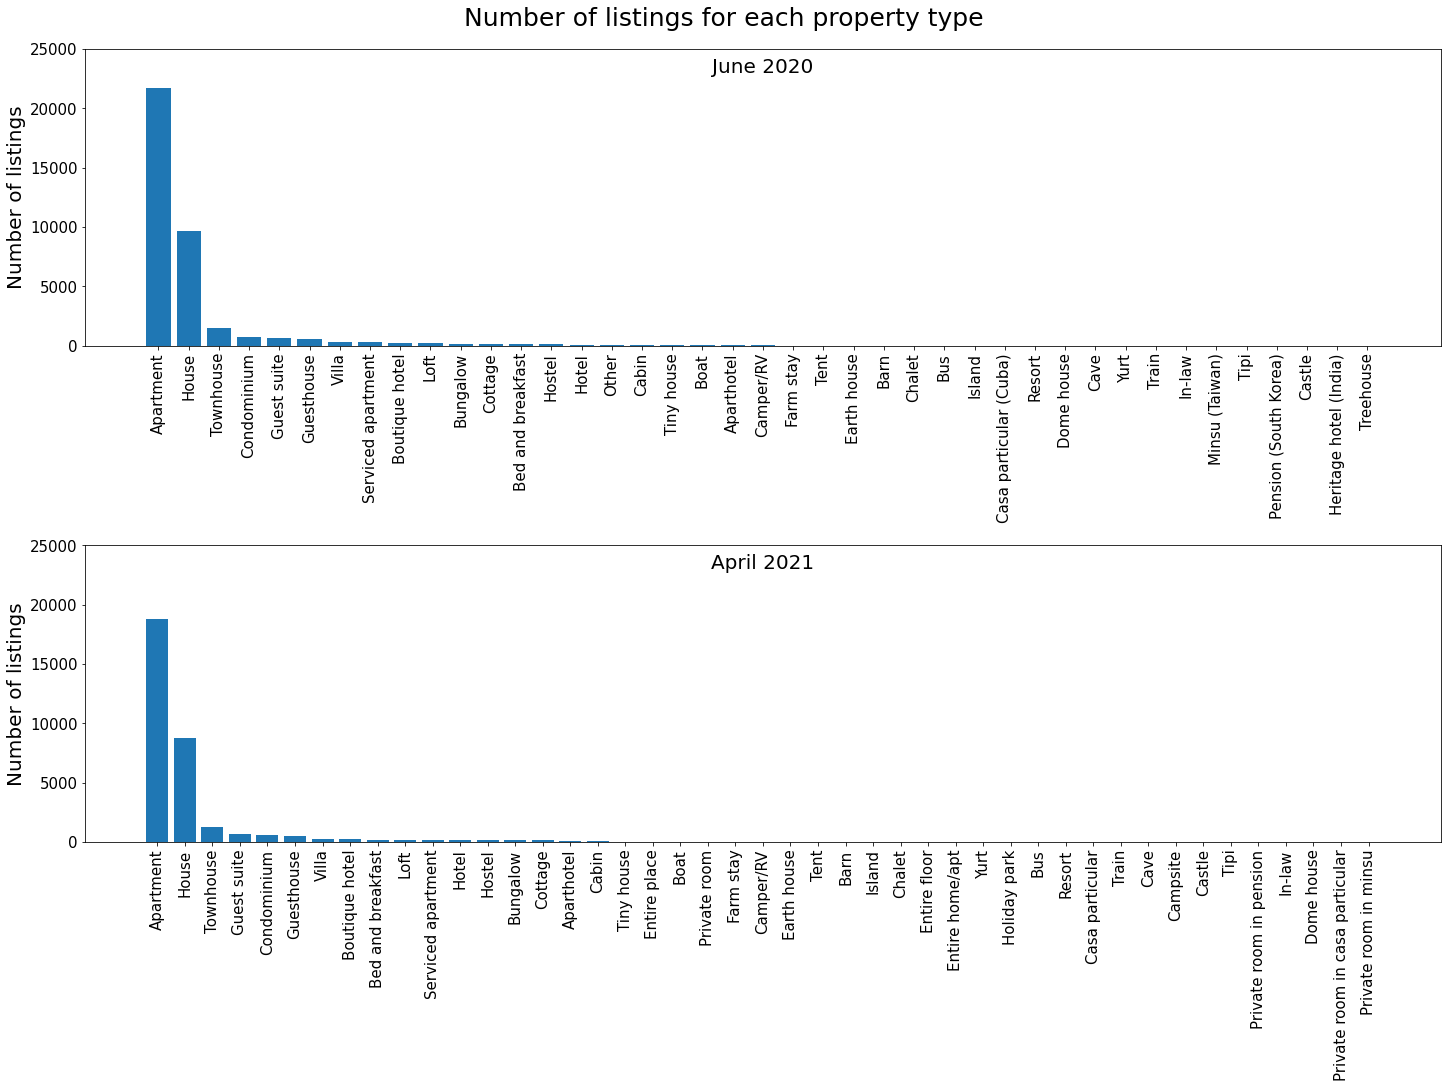

In [47]:
# Visulaize the number of listings of each property type for 'listings_20' and 'listings_21'

fig, ax = plt.subplots(2,1, figsize=[20,15], constrained_layout=True)
r = 0
labels = ['June 2020', 'April 2021']
for file in [listings_20, listings_21]:
    x = range(file.property_type.value_counts().shape[0])
    ax[r].bar(x, file.property_type.value_counts()) #Bar plot of the number of each property type
    ax[r].set_xticks(x)
    ax[r].set_xticklabels(file.property_type.value_counts().index, rotation=90, size=15)
    ax[r].tick_params(axis='y', labelsize=15)
    ax[r].set_ylabel('Number of listings', size=20)
    ax[r].set_ylim(0, 25000)
    ax[r].set_title(labels[r], y=0.9, size=20)
    r += 1
fig.suptitle('Number of listings for each property type', size=25);

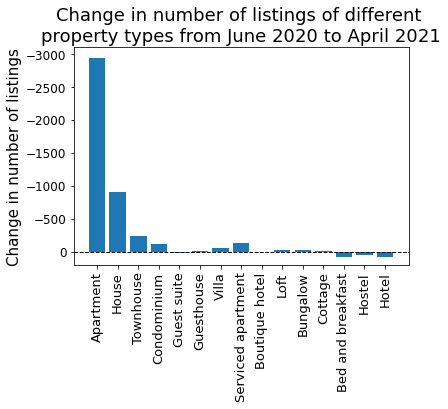

In [48]:
# Plot the change in each property type between the June 2020 and April 2021
idx = listings_20.property_type.value_counts().index #List of the 'property_type' categories in descending order of number
change = [] #List to append values of change for each category of 'property_type'
c_idx = [] #List to append the 'property_type' categories that are common to both years
for i in idx:
    if i not in listings_21.property_type.value_counts().index: # Only calculate change for categories common to both years
        None
    else:
        #Append the calculated differences to 'change' and the categories where calculated to 'c_idx'
        change.append(listings_21.property_type.value_counts()[i] - listings_20.property_type.value_counts()[i]) 
        c_idx.append(i)
#Plot the change for the 15 most common categories
plt.bar(c_idx[:15], change[:15])
plt.xticks(rotation=90, size=13)
plt.yticks(size=12)
plt.ylim(200, -3100)
plt.axhline(c='k', lw=1, ls='dashed')
plt.ylabel('Change in number of listings', size=15)
plt.title('Change in number of listings of different \nproperty types from June 2020 to April 2021', size=18);

Apartment listings have decreased by 3000 between June 2020 and April 2021.

In [49]:
# Create series with numbers of room types in the apartment category
apart_rt_20 = listings_20[listings_20.property_type == 'Apartment'].room_type.value_counts()
apart_rt_21 = listings_21[listings_21.property_type == 'Apartment'].room_type.value_counts()
apart_rt_20.shape[0] - apart_rt_21.shape[0] # Test whether the series are the same size

1

In [50]:
# Discover which category is missing from 'apart_rt_21'
apart_rt_20.index[~apart_rt_20.index.isin(apart_rt_21.index)]

Index(['Hotel room'], dtype='object')

In [51]:
# Set 'Hotel room' to zero in 'apart_rt_21'
apart_rt_21['Hotel room'] = 0

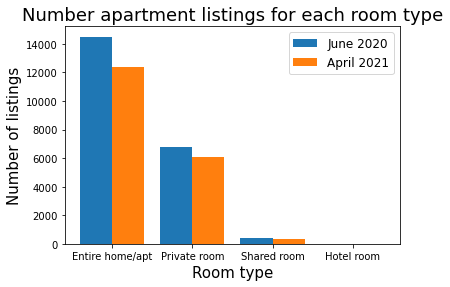

In [52]:
# Plot the number of apartment room types for both years
labels = apart_rt_20.index
width = 0.4
x = np.arange(1,5)
plt.bar(x-width/2, apart_rt_20, width=width, label='June 2020')
plt.bar(x+width/2, apart_rt_21, width=width, label='April 2021')
plt.xticks(ticks=x, labels=labels)
plt.yticks(size=10)
plt.ylabel('Number of listings', size=15)
plt.xlabel('Room type', size=15)
plt.title('Number apartment listings for each room type', size=18)
plt.legend(fontsize = 12);

In [53]:
# Changes from June 2020 to April 2021 in number of listed apartments by room type as *percentage*
percent_change = (apart_rt_20[:3] - apart_rt_21[:3])/apart_rt_20[:3]*100
percent_change

Entire home/apt    14.730019
Private room       10.788931
Shared room        15.594059
Name: room_type, dtype: float64

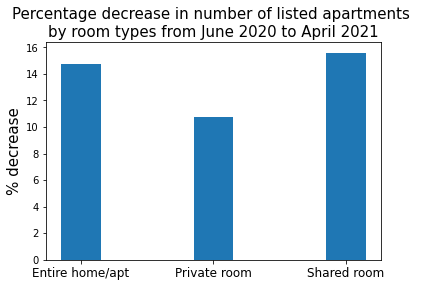

In [54]:
# Plot changes in number of listed apartments by room type as *percentage*
plt.bar([1,2,3], percent_change, width=0.3)
plt.xticks(ticks=[1,2,3], labels=percent_change.index, size=12)
plt.ylabel('% decrease', size=15)
plt.title('Percentage decrease in number of listed apartments \nby room types from June 2020 to April 2021', size=15);

In [55]:
# Inspect change in listings that only have one review in the last 12 months by property type
one_20 = listings_20[listings_20.number_of_reviews_ltm == 1].property_type.value_counts()
one_21 = listings_21[listings_21.number_of_reviews_ltm == 1].property_type.value_counts()
idx = one_20[one_20.index.isin(one_21.index)].index

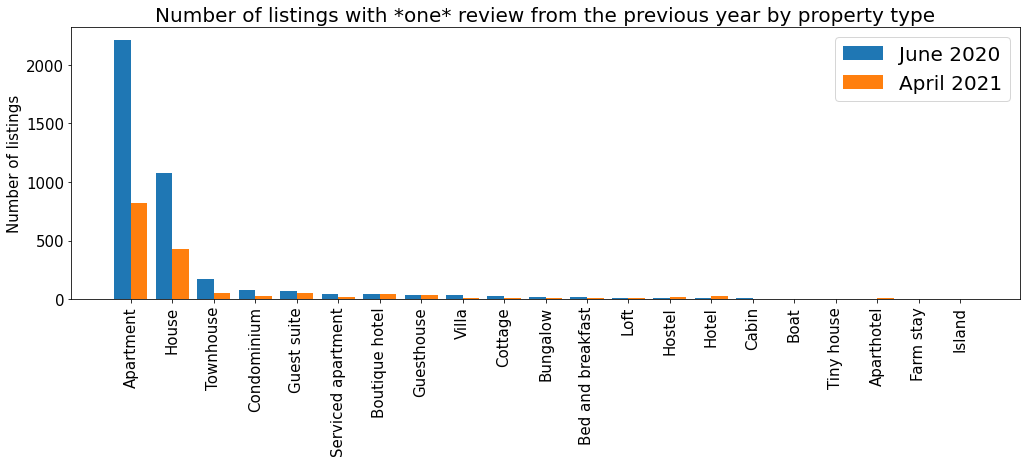

In [56]:
x = np.arange(one_20[idx].shape[0])
labels = idx
width = 0.4
plt.figure(figsize=(17,5))
plt.bar(x-width/2, one_20[idx], width=width, label='June 2020')
plt.bar(x+width/2, one_21[idx], width=width, label='April 2021')
plt.xticks(ticks=x, labels=labels, rotation=90, size=15)
plt.yticks(size=15)
plt.legend(fontsize=20, loc='upper right')
plt.ylabel('Number of listings',size=15)
plt.title('Number of listings with *one* review from the previous year by property type', size=20);

In [57]:
((one_20[idx] - one_21[idx])/one_20[idx]).sort_values(ascending=False)

Townhouse             0.690476
Cabin                 0.666667
Villa                 0.657143
Apartment             0.629529
Condominium           0.621951
House                 0.604824
Serviced apartment    0.545455
Cottage               0.500000
Bed and breakfast     0.437500
Bungalow              0.375000
Guest suite           0.273973
Loft                  0.071429
Guesthouse            0.026316
Farm stay             0.000000
Tiny house            0.000000
Island                0.000000
Boutique hotel       -0.100000
Hostel               -0.500000
Boat                 -1.000000
Hotel                -1.090909
Aparthotel           -2.000000
Name: property_type, dtype: float64

In [58]:
one_apart_20 = listings_20[listings_20.number_of_reviews_ltm == 1][listings_20.property_type == 'Apartment']
one_apart_20_rt = one_apart_20.room_type.value_counts()
one_apart_20_rt

<ipython-input-58-df8bf708dbd1>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  one_apart_20 = listings_20[listings_20.number_of_reviews_ltm == 1][listings_20.property_type == 'Apartment']


Entire home/apt    1519
Private room        649
Shared room          40
Name: room_type, dtype: int64

In [59]:
one_apart_21 = listings_21[listings_21.number_of_reviews_ltm == 1][listings_21.property_type == 'Apartment']
one_apart_21_rt = one_apart_21.room_type.value_counts()
one_apart_21_rt

<ipython-input-59-faaaa9c46e2b>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  one_apart_21 = listings_21[listings_21.number_of_reviews_ltm == 1][listings_21.property_type == 'Apartment']


Entire home/apt    642
Private room       175
Shared room          1
Name: room_type, dtype: int64

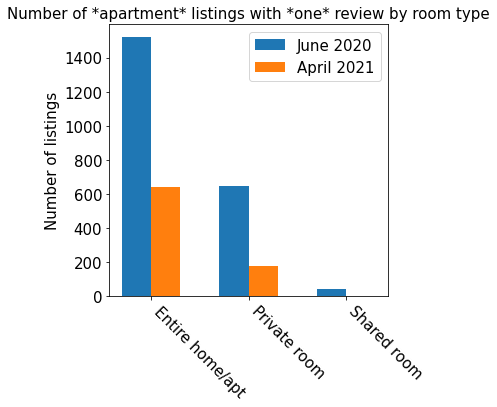

In [60]:
x = np.arange(3)
labels = one_apart_20_rt.index
width = 0.3
plt.figure(figsize=(5,5))
plt.bar(x-width/2, one_apart_20_rt, width=width, label='June 2020')
plt.bar(x+width/2, one_apart_21_rt, width=width, label='April 2021')
plt.xticks(ticks=x, labels=labels, rotation=-45, size=15, ha='left')
plt.yticks(size=15)
plt.ylabel('Number of listings', size=15)
plt.title('Number of *apartment* listings with *one* review by room type', size=15)
plt.legend(fontsize=15);

In [61]:
zero_apart_20 = listings_20[listings_20.number_of_reviews_ltm == 0][listings_20.property_type == 'Apartment']
zero_apart_20_rt = zero_apart_20.room_type.value_counts()
zero_apart_20_rt

<ipython-input-61-72d7b8872e1f>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  zero_apart_20 = listings_20[listings_20.number_of_reviews_ltm == 0][listings_20.property_type == 'Apartment']


Entire home/apt    7585
Private room       4630
Shared room         326
Name: room_type, dtype: int64

In [62]:
zero_apart_21 = listings_21[listings_21.number_of_reviews_ltm == 0][listings_21.property_type == 'Apartment']
zero_apart_21_rt = zero_apart_21.room_type.value_counts()
zero_apart_21_rt

<ipython-input-62-e19ebdc32126>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  zero_apart_21 = listings_21[listings_21.number_of_reviews_ltm == 0][listings_21.property_type == 'Apartment']


Entire home/apt    9083
Private room       5564
Shared room         331
Name: room_type, dtype: int64

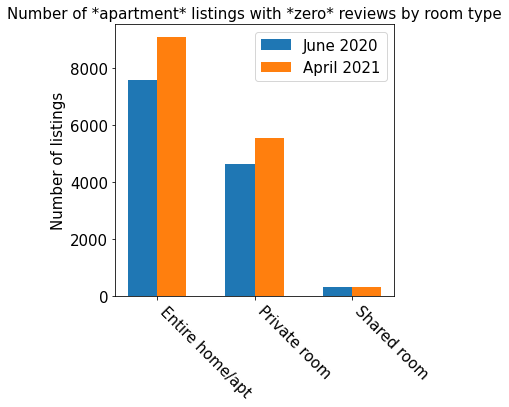

In [63]:
x = np.arange(3)
labels = zero_apart_20_rt.index
width = 0.3
plt.figure(figsize=(5,5))
plt.bar(x-width/2, zero_apart_20_rt, width=width, label='June 2020')
plt.bar(x+width/2, zero_apart_21_rt, width=width, label='April 2021')
plt.xticks(ticks=x, labels=labels, rotation=-45, size=15, ha='left')
plt.yticks(size=15)
plt.ylabel('Number of listings', size=15)
plt.title('Number of *apartment* listings with *zero* reviews by room type', size=15)
plt.legend(fontsize=15);

In [64]:
avail20_rev21 = pd.merge(listings_20[['id', 'availability_365']], listings_21[['id', 'number_of_reviews_ltm']])
avail20_rev21.shape

(28081, 3)

### Fun plot

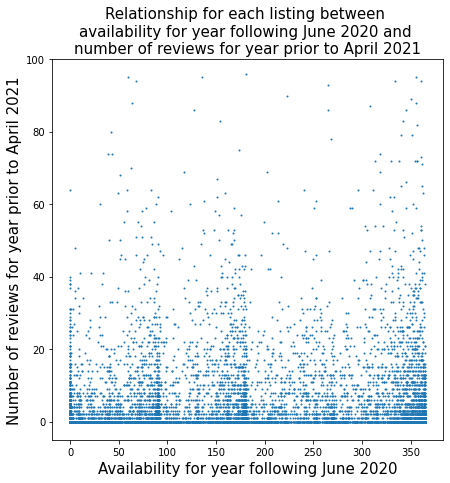

In [65]:
x = avail20_rev21.availability_365
y = avail20_rev21.number_of_reviews_ltm
plt.figure(figsize=(7,7))
plt.plot(x, y, ls='None', marker='o', ms=1)
plt.ylim(-5,100)
plt.xlabel('Availability for year following June 2020', size=15)
plt.ylabel('Number of reviews for year prior to April 2021', size=15)
plt.title('Relationship for each listing between \navailability for year following June 2020 and \nnumber of \
reviews for year prior to April 2021', size=15);

## Trends during period between June 2020 and April 2021

In [66]:
month = ['jul', 'aug', 'sep', 'oct', 'nov', 'dec', 'jan', 'feb', 'mar']

In [67]:
df_dict = {}
for m in month:
    df_dict[m] = pd.read_csv(r'C:\Users\z2216895\OneDrive - UNSW\Documents\General\Udacity\Data Scientist\Project-1\Sydney AirBnB\listings_{}.csv.gz'.format(m))

C:\Users\z2216895\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (49,57,58,88) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [68]:
df_dict['jun'] = listings_orig_20.copy()
df_dict['apr'] = listings_orig_21.copy()

In [69]:
temp = ['jun']
temp.extend(month)
temp.extend(['apr'])
month = temp
month

['jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr']

In [70]:
print('month      ', 'columns', '   common with April', '\n')
for m in month:
    print(m, df_dict[m].shape[1], df_dict['apr'].columns.isin(df_dict[m]).sum(), sep='         ')

month       columns    common with April 

jun         106         72
jul         101         67
aug         74         74
sep         74         74
oct         74         74
nov         74         74
dec         74         74
jan         74         74
feb         74         74
mar         74         74
apr         74         74


In [71]:
for m in month:
    print(m, df_dict[m][['property_type', 'room_type']].iloc[0].values)

jun ['Apartment' 'Private room']
jul ['Apartment' 'Private room']
aug ['Private room in apartment' 'Private room']
sep ['Private room in apartment' 'Private room']
oct ['Private room in apartment' 'Private room']
nov ['Private room in apartment' 'Private room']
dec ['Private room in apartment' 'Private room']
jan ['Private room in apartment' 'Private room']
feb ['Private room in apartment' 'Private room']
mar ['Private room in apartment' 'Private room']
apr ['Private room in apartment' 'Private room']


In [72]:
df_dict['apr'].columns[~df_dict['apr'].columns.isin(df_dict['jun'])]

Index(['bathrooms_text', 'number_of_reviews_l30d'], dtype='object')

In [73]:
df_dict['apr'].columns[~df_dict['apr'].columns.isin(df_dict['jul'])]

Index(['bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights'],
      dtype='object')

In [74]:
df_dict['jul'].columns[df_dict['jul'].columns.str.contains('bed' , case=False)]

Index(['bed_type'], dtype='object')

In [75]:
df_dict['jul'].bed_type.unique()

array(['Real Bed', nan, 'Pull-out Sofa', 'Futon', 'Airbed', 'Couch'],
      dtype=object)

In [76]:
df_dict['jul'][df_dict['jul'].columns[df_dict['jul'].columns.str.contains('price', case=False)]].head()

,weekly_price,monthly_price
0,NaN,NaN
1,$800.00,NaN
2,"$3,000.00",NaN
3,$800.00,"$3,000.00"
4,NaN,NaN


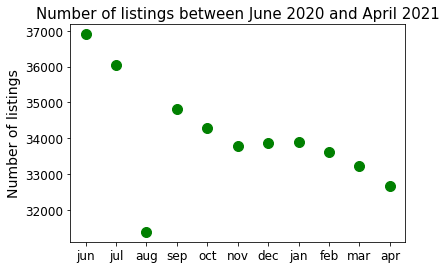

In [77]:
num_list_dict = {}
for m in month:
    num_list_dict[m] = df_dict[m].shape[0]
plt.plot(pd.Series(num_list_dict), ls='None', marker='o', c='g', ms=10)
plt.xticks(size=12)
plt.yticks(size=12)
plt.ylabel('Number of listings',size=14)
plt.title('Number of listings between June 2020 and April 2021', size=15);

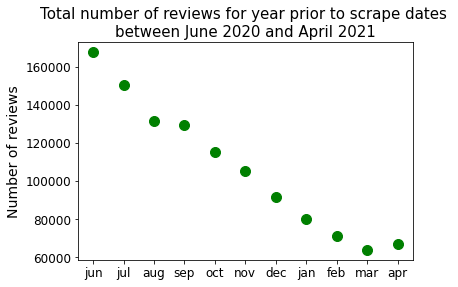

In [78]:
num_rev_dict = {}
for m in month:
    num_rev_dict[m] = df_dict[m].number_of_reviews_ltm.sum()
plt.plot(pd.Series(num_rev_dict), ls='None', marker='o', c='g', ms=10)
plt.xticks(size=12)
plt.yticks(size=12)
plt.ylabel('Number of reviews',size=14)
plt.title('Total number of reviews for year prior to scrape dates \nbetween June 2020 and April 2021', size=15);

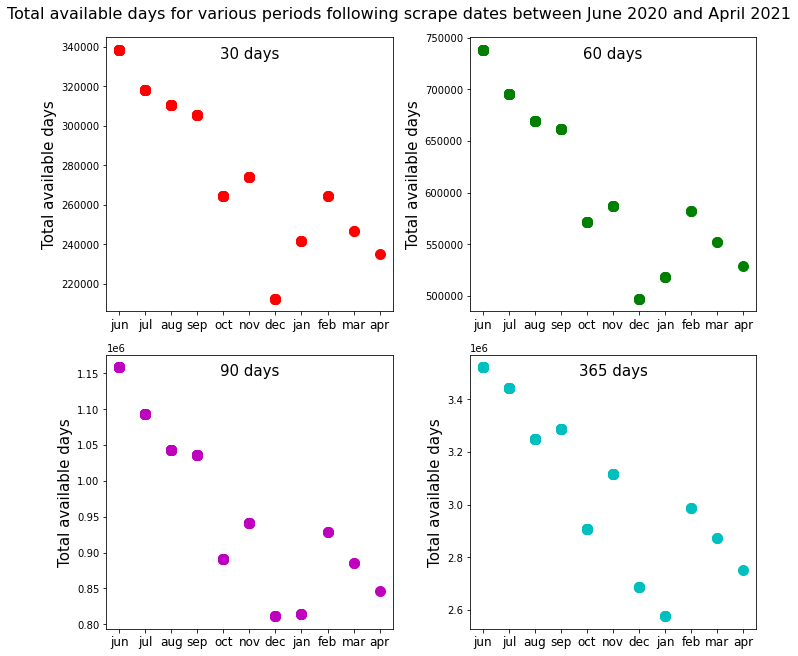

In [79]:
fig, ax = plt.subplots(2,2, figsize=[10,9], constrained_layout=True)
period = ['30', '60', '90', '365']
col = ['r', 'g', 'm', 'c']
n = 0
for days in period:
    avail_dict = {}
    for m in month:
        avail_dict[m] = df_dict[m]['availability_'+days].sum()
        r = n//2
        c = n%2
        ax[r,c].plot(pd.Series(avail_dict), ls='None', marker='o', ms=10, c=col[n])
        ax[r,c].set_title(days+' days', y=0.9, size=15)
        ax[r,c].set_ylabel('Total available days',size=15)
        ax[r,c].tick_params(axis='x', labelsize=12)
        fig.suptitle('Total available days for various periods following scrape dates between June 2020 and April 2021', size=16)
    n += 1

In [80]:
for m in month:
    print(df_dict[m].columns[df_dict[m].columns.str.contains('price' , case=False)])

Index(['price', 'weekly_price', 'monthly_price'], dtype='object')
Index(['weekly_price', 'monthly_price'], dtype='object')
Index(['price'], dtype='object')
Index(['price'], dtype='object')
Index(['price'], dtype='object')
Index(['price'], dtype='object')
Index(['price'], dtype='object')
Index(['price'], dtype='object')
Index(['price'], dtype='object')
Index(['price'], dtype='object')
Index(['price'], dtype='object')


In [81]:
mth = month.copy()
mth.remove('jul')
for m in mth:
    print(df_dict[m].price.isna().sum())

0
0
0
0
0
0
0
0
0
0


In [82]:
for m in mth:
    df_dict[m].price = df_dict[m].price.replace('[\$,]', '',regex=True).astype(float).astype(int)

In [83]:
for m in mth:
    print(df_dict[m].price.dtypes)

int32
int32
int32
int32
int32
int32
int32
int32
int32
int32


In [84]:
for m in month:
    print(m, df_dict[m].property_type[0])

jun Apartment
jul Apartment
aug Private room in apartment
sep Private room in apartment
oct Private room in apartment
nov Private room in apartment
dec Private room in apartment
jan Private room in apartment
feb Private room in apartment
mar Private room in apartment
apr Private room in apartment


In [85]:
# Values in 'listings_21.property_type' containing 'Boutique hotel' are changed first in oder to avoid changing them to 
# 'Hotel' in an earlier loop since 'Boutique hotel' > 'Hotel' in 'listings_20.property_type'

# Create a list of the categories in 'df_dict('jun').property_type' with 'Boutique hotel' removed. The values in this list
# will be used for search and replace of the categories in the listings for the remaining months, expect July.
pt_cats = df_dict['jun'].property_type.value_counts(ascending=True).index.drop('Boutique hotel') 

for m in month:
    if m == 'jun' or m == 'jul':
        None
    else:
        temp = df_dict[m].property_type.copy() #Create a temporary copy of the unchanged 'listings_21.property_type' 
        changed = pd.Series(np.zeros(temp.shape), dtype='boolean') #Create series 'changed' of the same shape as 'temp' to record changes
        pt = 'Boutique hotel'
        idx = temp[temp.str.contains(pt, case=False)].index #Identify the index values for listings containing 'Boutique hotel'
        idx_new = temp[idx][changed[idx] == False].index #Check that the listings of with index 'idx' haven't already been changed 
        temp[idx_new] = pt #Change the identified values of 'listings_21.property_type' to 'Boutique hotel'
        changed[idx_new] = True #Record the indexes changed listings
        # Create a list of the categories in 'listings_20.property_type' with 'Boutique hotel' removed

        # Loop through all the categories of 'listings_20.property_type' using the same logic as above
        for pt in pt_cats:
            idx = temp[temp.str.contains(pt, case=False)].index #Index values of listings containing pt
            idx_new = temp[idx][changed[idx] == False].index #Index values that are unchanged
            temp[idx_new] = pt #Change to pt
            changed[idx_new] = True #Record the index of changed listings
        df_dict[m].property_type = temp #Replace values of 'listings_21.property_type' with temp
        print(df_dict[m].property_type.value_counts().shape)

C:\Users\z2216895\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
C:\Users\z2216895\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
C:\Users\z2216895\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
C:\Users\z2216895\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


(45,)


C:\Users\z2216895\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
C:\Users\z2216895\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
C:\Users\z2216895\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
C:\Users\z2216895\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


(44,)


C:\Users\z2216895\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
C:\Users\z2216895\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
C:\Users\z2216895\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
C:\Users\z2216895\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


(45,)


C:\Users\z2216895\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
C:\Users\z2216895\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
C:\Users\z2216895\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
C:\Users\z2216895\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


(45,)


C:\Users\z2216895\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
C:\Users\z2216895\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
C:\Users\z2216895\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
C:\Users\z2216895\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


(44,)


C:\Users\z2216895\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
C:\Users\z2216895\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
C:\Users\z2216895\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
C:\Users\z2216895\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


(44,)


C:\Users\z2216895\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
C:\Users\z2216895\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
C:\Users\z2216895\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
C:\Users\z2216895\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


(45,)


C:\Users\z2216895\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
C:\Users\z2216895\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
C:\Users\z2216895\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
C:\Users\z2216895\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


(44,)


C:\Users\z2216895\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
C:\Users\z2216895\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
C:\Users\z2216895\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
C:\Users\z2216895\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


(45,)


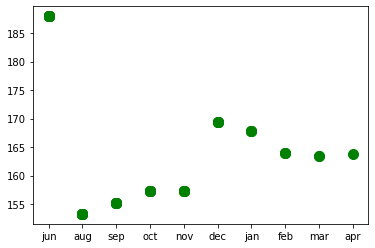

In [86]:
mean_price_dict = {}
for m in mth:
    mean_price_dict[m] = df_dict[m][df_dict[m].property_type == 'Apartment'].price.mean()
    plt.plot(pd.Series(mean_price_dict), ls='None', marker='o', c='g', ms=10)

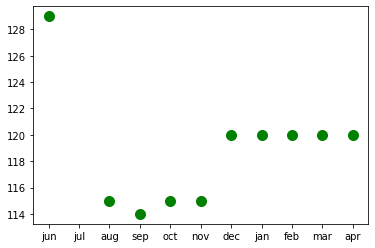

In [87]:
median_price_dict = {}
for m in month:
    if m == 'jul':
        median_price_dict[m] = np.nan
    else:
        median_price_dict[m] = df_dict[m][df_dict[m].property_type == 'Apartment'].price.median()
plt.plot(pd.Series(median_price_dict), ls='None', marker='o', c='g', ms=10);

<ipython-input-88-0df4a83e451e>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  median_price_dict[m] = df_dict[m][df_dict[m].property_type == 'Apartment'] \


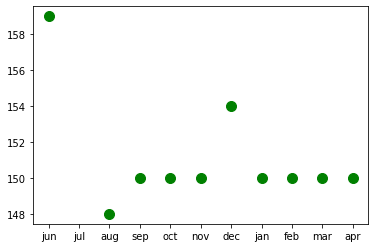

In [88]:
median_price_dict = {}
for m in month:
    if m == 'jul':
        median_price_dict[m] = np.nan
    else:
        median_price_dict[m] = df_dict[m][df_dict[m].property_type == 'Apartment'] \
                                         [df_dict[m].room_type == 'Entire home/apt'].price.median()
plt.plot(pd.Series(median_price_dict), ls='None', marker='o', c='g', ms=10);

In [89]:
counts = df_dict[m][df_dict[m].property_type == 'Apartment'][df_dict[m].room_type == 'Entire home/apt'].bedrooms.value_counts()
counts.iloc[0]

<ipython-input-89-906f4e863730>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  counts = df_dict[m][df_dict[m].property_type == 'Apartment'][df_dict[m].room_type == 'Entire home/apt'].bedrooms.value_counts()


5553

<ipython-input-90-5ad8b6c987aa>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  counts = df_dict[m][df_dict[m].property_type == 'Apartment'] \
<ipython-input-90-5ad8b6c987aa>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  median_price_dict[m] = df_dict[m][df_dict[m].property_type == 'Apartment'] \


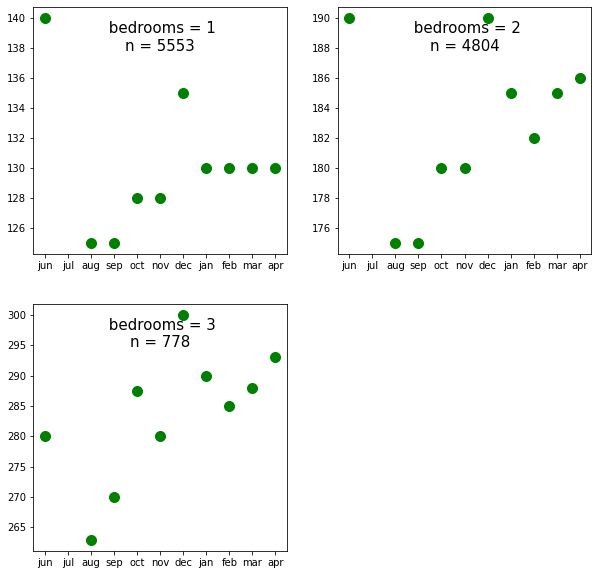

In [90]:
counts = df_dict[m][df_dict[m].property_type == 'Apartment'] \
                   [df_dict[m].room_type == 'Entire home/apt'].bedrooms.value_counts()

fig, ax = plt.subplots(2,2, figsize=[10,10])
n = 0
for bedrms in [1,2,3]:
    median_price_dict = {}
    for m in month:
        if m == 'jul':
            median_price_dict[m] = np.nan
        else:
            median_price_dict[m] = df_dict[m][df_dict[m].property_type == 'Apartment'] \
                                             [df_dict[m].room_type == 'Entire home/apt'] \
                                             [df_dict[m].bedrooms == bedrms].price.median()
    r = n//2
    c = n%2
    ax[r,c].plot(pd.Series(median_price_dict), ls='None', marker='o', c='g', ms=10)
    #ax[r,c].tick_params(axis='x', labelrotation=90)
    ax[r,c].set_title(' bedrooms = '+str(bedrms)+'\nn = '+str(counts.iloc[bedrms-1]), y=0.8, size=15)
    n += 1
ax[1,1].set_axis_off();

## Model investigations
### Developing pipeline
Features - harmonize, bathrooms  
Dtypes  
Categorical  

#### Features - harmonize columns, bathrooms

In [91]:
mth = month.copy()
mth.remove('jul')
for m in mth:
    print(m, df_dict[m].shape[1], ' columns')

jun 106  columns
aug 74  columns
sep 74  columns
oct 74  columns
nov 74  columns
dec 74  columns
jan 74  columns
feb 74  columns
mar 74  columns
apr 74  columns


In [92]:
d = month.copy()
d.remove('jun')
d.remove('jul')
mth_atoa = d
mth_atoa

['aug', 'sep', 'oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr']

In [93]:
for m in mth_atoa:
    print(m, df_dict[m].columns[~df_dict[m].columns.isin(df_dict['apr'].columns)].values)

aug []
sep []
oct []
nov []
dec []
jan []
feb []
mar []
apr []


In [94]:
print(df_dict['jun'].columns[~df_dict['jun'].columns.isin(df_dict['apr'].columns)].shape[0], 'columns in June file not in April file')
df_dict['jun'].columns[~df_dict['jun'].columns.isin(df_dict['apr'].columns)]

34 columns in June file not in April file


Index(['summary', 'space', 'experiences_offered', 'notes', 'transit', 'access',
       'interaction', 'house_rules', 'thumbnail_url', 'medium_url',
       'xl_picture_url', 'street', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'is_location_exact',
       'bed_type', 'square_feet', 'weekly_price', 'monthly_price',
       'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people',
       'requires_license', 'jurisdiction_names', 'is_business_travel_ready',
       'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification'],
      dtype='object')

In [95]:
idx = df_dict['jun'].columns[~df_dict['jun'].columns.isin(df_dict['apr'].columns)]
idx
df_dict['jun'].drop(idx, axis=1, inplace=True)
df_dict['jun'].shape

(36901, 72)

In [96]:
# The two columns in April that are missing from June
df_dict['apr'].columns[~df_dict['apr'].columns.isin(df_dict['jun'].columns)]

Index(['bathrooms_text', 'number_of_reviews_l30d'], dtype='object')

In [97]:
#June bathroom-related columns
idx = df_dict['jun'].columns[df_dict['jun'].columns.str.contains('bath')]
df_dict['jun'][idx].head()

,bathrooms
0,1.0
1,1.0
2,3.0
3,1.0
4,1.0


In [98]:
#April bathroom-related columns
idx = df_dict['apr'].columns[df_dict['apr'].columns.str.contains('bath')]
df_dict['apr'][idx].head()

,bathrooms,bathrooms_text
0,NaN,1 shared bath
1,NaN,1 shared bath
2,NaN,3 baths
3,NaN,1 private bath
4,NaN,1 bath


In [99]:
# Convert 'bathrooms_text' in files August to April to number and rename as 'bathrooms'

for m in mth_atoa:
    # Create new series as a copy of listings.bathrooms_text
    bathrooms = df_dict[m].bathrooms_text.copy() 

    # Create an index containing the index values for entries containg a number
    idx = bathrooms[bathrooms.str.contains('\d').astype('boolean')].index

    # Extract the float number from the entries with index in idx
    temp = pd.Series([float(re.findall(r'[\d\.\d]+', bathrooms[n])[0]) for n in idx],
                     index = idx, name = 'num_baths')
    # Replace the entries with an index in idx with a float number
    for n in idx:
        bathrooms[n] = temp[n].copy()
    
    #Convert half-baths to number 0.5
    idx = bathrooms[bathrooms.str.contains('half', case=False).astype('boolean')].index
    for n in idx:
        bathrooms[n] = 0.5
    bathrooms = bathrooms.astype(float)
    
    df_dict[m].bathrooms = bathrooms
    df_dict[m].drop('bathrooms_text', axis=1, inplace=True)
    
    print(df_dict[m].bathrooms[0])
    

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [100]:
for m in mth_atoa:
    df_dict[m].drop('number_of_reviews_l30d', axis=1, inplace=True)

In [101]:
for m in mth:
    print(df_dict[m].shape)

(36901, 72)
(31391, 72)
(34829, 72)
(34276, 72)
(33795, 72)
(33871, 72)
(33902, 72)
(33630, 72)
(33229, 72)
(32679, 72)


#### Dtypes

In [102]:
df_dict['apr'].dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64'), dtype('int32')],
      dtype=object)

**First look at the *number* dtypes**

In [103]:
f_64 = df_dict['apr'].dtypes[df_dict[m].dtypes == 'float64'].index
i_64 = df_dict['apr'].dtypes[df_dict[m].dtypes == 'int64'].index
i_32 = df_dict['apr'].dtypes[df_dict[m].dtypes == 'int32'].index
for m in mth:
    f_64_m = df_dict[m].dtypes[df_dict[m].dtypes == 'float64'].index
    i_64_m = df_dict[m].dtypes[df_dict[m].dtypes == 'int64'].index
    i_32_m = df_dict[m].dtypes[df_dict[m].dtypes == 'int32'].index
    print(m, f_64_m[~f_64_m.isin(f_64)].values, i_64_m[~i_64_m.isin(i_64)].values, i_32_m[~i_32_m.isin(i_32)].values)

jun [] [] []
aug [] [] []
sep [] [] []
oct ['minimum_minimum_nights' 'maximum_minimum_nights'
 'minimum_maximum_nights' 'maximum_maximum_nights'] [] []
nov [] [] []
dec [] [] []
jan [] [] []
feb [] [] []
mar [] [] []
apr [] [] []


In [104]:
df_dict['oct'][['minimum_minimum_nights', 'maximum_minimum_nights',
                'minimum_maximum_nights', 'maximum_maximum_nights']].dtypes

minimum_minimum_nights    float64
maximum_minimum_nights    float64
minimum_maximum_nights    float64
maximum_maximum_nights    float64
dtype: object

In [105]:
df_dict['apr'][['minimum_minimum_nights', 'maximum_minimum_nights',
                'minimum_maximum_nights', 'maximum_maximum_nights']].dtypes

minimum_minimum_nights    int64
maximum_minimum_nights    int64
minimum_maximum_nights    int64
maximum_maximum_nights    int64
dtype: object

In [106]:
df_dict['oct'][['minimum_minimum_nights', 'maximum_minimum_nights',
                'minimum_maximum_nights', 'maximum_maximum_nights']].isna().sum()

minimum_minimum_nights    3
maximum_minimum_nights    3
minimum_maximum_nights    3
maximum_maximum_nights    3
dtype: int64

In [107]:
for col in ['minimum_minimum_nights', 'maximum_minimum_nights',
                'minimum_maximum_nights', 'maximum_maximum_nights']:
    df_dict['oct'][col].fillna(value=-1, inplace=True)

In [108]:
df_dict['oct'].loc[:, ['minimum_minimum_nights', 'maximum_minimum_nights',
                'minimum_maximum_nights', 'maximum_maximum_nights']].isna().sum()

minimum_minimum_nights    0
maximum_minimum_nights    0
minimum_maximum_nights    0
maximum_maximum_nights    0
dtype: int64

In [109]:
for col in ['minimum_minimum_nights', 'maximum_minimum_nights',
                'minimum_maximum_nights', 'maximum_maximum_nights']:
    df_dict['oct'][col] = df_dict['oct'][col].astype('int64')

In [110]:
f_64 = df_dict['apr'].dtypes[df_dict[m].dtypes == 'float64'].index
i_64 = df_dict['apr'].dtypes[df_dict[m].dtypes == 'int64'].index
i_32 = df_dict['apr'].dtypes[df_dict[m].dtypes == 'int32'].index
for m in mth:
    f_64_m = df_dict[m].dtypes[df_dict[m].dtypes == 'float64'].index
    i_64_m = df_dict[m].dtypes[df_dict[m].dtypes == 'int64'].index
    i_32_m = df_dict[m].dtypes[df_dict[m].dtypes == 'int32'].index
    print(m, f_64_m[~f_64_m.isin(f_64)].values, i_64_m[~i_64_m.isin(i_64)].values, i_32_m[~i_32_m.isin(i_32)].values)

jun [] [] []
aug [] [] []
sep [] [] []
oct [] [] []
nov [] [] []
dec [] [] []
jan [] [] []
feb [] [] []
mar [] [] []
apr [] [] []


**Check for % signs and change to number dtype**

In [111]:
print('Month    column      contains %  NaNs')
for m in mth:
    for idx in df_dict[m].dtypes[df_dict[m].dtypes == 'object'].index:
        if df_dict[m][idx].str.contains('%').sum() > 1000:
            missing_vals = df_dict[m][idx].isna().sum()
            print(m, idx, df_dict[m][idx].str.contains('%').sum(), missing_vals, flush=True)

Month    column      contains %  NaNs
jun host_response_rate 14121 22780
jun host_acceptance_rate 22804 14097
aug host_response_rate 12243 19148
aug host_acceptance_rate 18913 12478
sep host_response_rate 12493 22336
sep host_acceptance_rate 19728 15101
oct host_response_rate 12086 22190
oct host_acceptance_rate 18762 15514
nov host_response_rate 12382 21413
nov host_acceptance_rate 18006 15789
dec host_response_rate 14146 19725
dec host_acceptance_rate 17416 16455
jan host_response_rate 14110 19792
jan host_acceptance_rate 16472 17430
feb host_response_rate 13439 20191
feb host_acceptance_rate 15518 18112
mar host_response_rate 12660 20569
mar host_acceptance_rate 14395 18834
apr host_response_rate 11778 20901
apr host_acceptance_rate 13343 19336


In [112]:
# Remove '%' character and convert to integer
for m in mth:
    for col in ['host_response_rate','host_acceptance_rate']:
        df_dict[m][col] = df_dict[m][col].str.replace('%', '').astype(float).astype('Int64')
    print(m, df_dict[m][['host_response_rate','host_acceptance_rate']].dtypes)

jun host_response_rate      Int64
host_acceptance_rate    Int64
dtype: object
aug host_response_rate      Int64
host_acceptance_rate    Int64
dtype: object
sep host_response_rate      Int64
host_acceptance_rate    Int64
dtype: object
oct host_response_rate      Int64
host_acceptance_rate    Int64
dtype: object
nov host_response_rate      Int64
host_acceptance_rate    Int64
dtype: object
dec host_response_rate      Int64
host_acceptance_rate    Int64
dtype: object
jan host_response_rate      Int64
host_acceptance_rate    Int64
dtype: object
feb host_response_rate      Int64
host_acceptance_rate    Int64
dtype: object
mar host_response_rate      Int64
host_acceptance_rate    Int64
dtype: object
apr host_response_rate      Int64
host_acceptance_rate    Int64
dtype: object


**Change 't'/'f' columns to 'boolean' dtype**

In [113]:
d = {'t': True, 'f': False}
for m in mth:
    for col in df_dict[m].dtypes[df_dict[m].dtypes == 'object'].index:
        if round((df_dict[m][col].str.len() == 1).mean()) == 1:
            df_dict[m][col] = df_dict[m][col].map(d).astype(bool)

In [114]:
# Check boolean dtypes for August
df_dict['aug'].dtypes[df_dict['aug'].dtypes == bool]

host_is_superhost         bool
host_has_profile_pic      bool
host_identity_verified    bool
has_availability          bool
instant_bookable          bool
dtype: object

**Change dates as 'object' dtypes to time intervals to scrape date**

In [115]:
for m in mth:
    cols = []
    for col in df_dict[m].dtypes[df_dict[m].dtypes == 'object'].index:
        if df_dict[m][col].str.startswith('202').mean() > 0.1:
            cols.append(col)
    
    for col in cols:
        df_dict[m][col] = pd.to_datetime(df_dict[m][col], infer_datetime_format=True, errors='ignore')
    print(m, cols)
    print(df_dict[m][cols].dtypes)

jun ['last_scraped', 'calendar_last_scraped', 'first_review', 'last_review']
last_scraped             datetime64[ns]
calendar_last_scraped    datetime64[ns]
first_review             datetime64[ns]
last_review              datetime64[ns]
dtype: object
aug ['last_scraped', 'calendar_last_scraped', 'first_review', 'last_review']
last_scraped             datetime64[ns]
calendar_last_scraped    datetime64[ns]
first_review             datetime64[ns]
last_review              datetime64[ns]
dtype: object
sep ['last_scraped', 'calendar_last_scraped', 'first_review', 'last_review']
last_scraped             datetime64[ns]
calendar_last_scraped    datetime64[ns]
first_review             datetime64[ns]
last_review              datetime64[ns]
dtype: object
oct ['last_scraped', 'calendar_last_scraped', 'first_review', 'last_review']
last_scraped             datetime64[ns]
calendar_last_scraped    datetime64[ns]
first_review             datetime64[ns]
last_review              datetime64[ns]
dtype: obj

In [116]:
cols = df_dict['aug'].dtypes[df_dict['aug'].dtypes == 'datetime64[ns]'].index
cols

Index(['last_scraped', 'calendar_last_scraped', 'first_review', 'last_review'], dtype='object')

In [117]:
scrape_date_dict = {'jun':'2020-06-11','jul':'2020-07-14','aug':'2020-08-20','sep':'2020-09-10','oct':'2020-10-11',
                    'nov':'2020-11-05','dec':'2020-12-14','jan':'2021-01-10','feb':'2021-02-08','mar':'2021-03-04',
                    'apr':'2021-04-20'}
dt_dict = {}
for m in mth:
    current = pd.Timestamp(scrape_date_dict[m])
    dt_dict[m] = pd.DataFrame([])
    for col in cols:
        dt_dict[m][col] = current - df_dict[m][col]
        df_dict[m][col] = dt_dict[m][col].dt.days
        df_dict[m].loc[df_dict[m][col] < -1e10, col] = None
        df_dict[m][col] = df_dict[m][col].astype('Int64')

In [118]:
df_dict['mar'][cols].dtypes

last_scraped             Int64
calendar_last_scraped    Int64
first_review             Int64
last_review              Int64
dtype: object

In [119]:
# Columns remaining of dtype 'object'
df_dict['jun'].dtypes[df_dict['jun'].dtypes == 'object']

listing_url               object
name                      object
description               object
neighborhood_overview     object
picture_url               object
host_url                  object
host_name                 object
host_since                object
host_location             object
host_about                object
host_response_time        object
host_thumbnail_url        object
host_picture_url          object
host_neighbourhood        object
host_verifications        object
neighbourhood             object
neighbourhood_cleansed    object
property_type             object
room_type                 object
amenities                 object
calendar_updated          object
license                   object
dtype: object

In [120]:
'''
for m in mth:
    idx = df_dict[m].isna().sum()[df_dict[m].isna().sum() > 0].index #Columns with missing values
    for col in idx:
        df_dict[m].loc[:,col] = df_dict[m].loc[:,col].fillna(df_dict[m].loc[:,col].median()) #Fill missing values with median
'''

'\nfor m in mth:\n    idx = df_dict[m].isna().sum()[df_dict[m].isna().sum() > 0].index #Columns with missing values\n    for col in idx:\n        df_dict[m].loc[:,col] = df_dict[m].loc[:,col].fillna(df_dict[m].loc[:,col].median()) #Fill missing values with median\n'

**Dummy variables for remaining categorical features**

In [121]:
cols = df_dict['jun'].dtypes[df_dict['jun'].dtypes == 'object'].index
df_dict['jun'][cols[0:11]].head()

,listing_url,name,description,neighborhood_overview,picture_url,host_url,host_name,host_since,host_location,host_about,host_response_time
0,https://www.airbnb.com/rooms/11156,An Oasis in the City,Very central to the city which can be reached ...,"It is very close to everything and everywhere,...",https://a0.muscache.com/im/pictures/2797669/17...,https://www.airbnb.com/users/show/40855,Colleen,2009-09-23,"Potts Point, New South Wales, Australia","Recently retired, I've lived & worked on 4 con...",NaN
1,https://www.airbnb.com/rooms/12351,Sydney City & Harbour at the door,Come stay with Vinh & Stuart (Awarded as one o...,"Pyrmont is an inner-city village of Sydney, on...",https://a0.muscache.com/im/pictures/763ad5c8-c...,https://www.airbnb.com/users/show/17061,Stuart,2009-05-14,"Sydney, New South Wales, Australia","G'Day from Australia!\r\n\r\nHe's Vinh, and I'...",NaN
2,https://www.airbnb.com/rooms/14250,Manly Harbour House,"Beautifully renovated, spacious and quiet, our...",Balgowlah Heights is one of the most prestigio...,https://a0.muscache.com/im/pictures/56935671/f...,https://www.airbnb.com/users/show/55948,Heidi,2009-11-20,"Sydney, New South Wales, Australia",I am a Canadian who has made Australia her hom...,within a few hours
3,https://www.airbnb.com/rooms/44545,Sunny Darlinghurst Warehouse Apartment,Sunny warehouse/loft apartment in the heart of...,Darlinghurst is home to some of Sydney's best ...,https://a0.muscache.com/im/pictures/a88d8e14-4...,https://www.airbnb.com/users/show/112237,Atari,2010-04-22,"Sydney, New South Wales, Australia",Curious about the world and full of wanderlust...,NaN
4,https://www.airbnb.com/rooms/58506,"Studio Yindi @ Mosman, Sydney","An open plan apartment, which opens onto a spa...","Mosman is a smart, middle to upper class subur...",https://a0.muscache.com/im/pictures/23497720/d...,https://www.airbnb.com/users/show/279955,John,2010-11-06,"Sydney, New South Wales, Australia",Faber est suae quisquae fortunae\r\n\r\nWe bec...,within a few hours


In [122]:
df_dict['jun'][cols[11:23]].head()

,host_thumbnail_url,host_picture_url,host_neighbourhood,host_verifications,neighbourhood,neighbourhood_cleansed,property_type,room_type,amenities,calendar_updated,license
0,https://a0.muscache.com/im/users/40855/profile...,https://a0.muscache.com/im/users/40855/profile...,Potts Point,"['email', 'phone', 'reviews']",Elizabeth Bay/Rushcutters Bay,Sydney,Apartment,Private room,"{TV,Wifi,Kitchen,Elevator,""Buzzer/wireless int...",3 months ago,NaN
1,https://a0.muscache.com/im/users/17061/profile...,https://a0.muscache.com/im/users/17061/profile...,Pyrmont,"['email', 'phone', 'manual_online', 'reviews',...",Pyrmont,Sydney,Townhouse,Private room,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",7 months ago,NaN
2,https://a0.muscache.com/im/users/55948/profile...,https://a0.muscache.com/im/users/55948/profile...,Balgowlah,"['email', 'phone', 'reviews', 'jumio', 'offlin...",Balgowlah,Manly,House,Entire home/apt,"{TV,Wifi,""Air conditioning"",Kitchen,""Pets live...",2 months ago,NaN
3,https://a0.muscache.com/im/pictures/user/34708...,https://a0.muscache.com/im/pictures/user/34708...,Darlinghurst,"['email', 'phone', 'facebook', 'reviews', 'jum...",Surry Hills,Sydney,Loft,Entire home/apt,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",6 months ago,NaN
4,https://a0.muscache.com/im/pictures/user/dd4ec...,https://a0.muscache.com/im/pictures/user/dd4ec...,Mosman,"['email', 'phone', 'facebook', 'reviews', 'jum...",Mosman,Mosman,House,Entire home/apt,"{TV,Wifi,Kitchen,""Free street parking"",Heating...",5 weeks ago,NaN


In [123]:
# Inspection of dtype 'object columns for the *number of categories* and *number of missing values* in each
temp = pd.DataFrame(df_dict['jun'].dtypes[df_dict['jun'].dtypes == 'object'], columns=['dtype'])
temp['no. of categories'] = pd.Series([np.zeros(4)])
temp['no. of NaNs'] = pd.Series([np.zeros(4)])
cols_obj = df_dict['jun'].dtypes[df_dict['jun'].dtypes == 'object'].index

for col in cols_obj:
    temp.loc[col, 'no. of categories'] = df_dict['jun'][col].unique().shape[0]
    temp.loc[col, 'no. of NaNs'] = df_dict['jun'][col].isna().sum()
                        
temp                        

,dtype,no. of categories,no. of NaNs
listing_url,object,36901,0
name,object,35977,12
description,object,34746,1259
neighborhood_overview,object,20090,14367
picture_url,object,36226,0
host_url,object,26947,0
host_name,object,8206,7
host_since,object,3420,7
host_location,object,1640,51
host_about,object,12873,17147


An examination of the remaining 'object' dtypes shows that only a subset are amenable to conversion to a dummy variable format. These are:

- host repsonse time
- neighbourhood
- neighbourhood_cleansed
- property_type
- room_type

Inspect the number of categories and missing values for each of the selected columns for each month.  

In [124]:
# Inspect the *number of categories* and *number of missing values* in the selected columns for each month
cols = ['host_response_time', 'neighbourhood', 'neighbourhood_cleansed', 'property_type', 'room_type']
for m in mth:
    temp = pd.DataFrame(df_dict[m][cols].dtypes, columns=['dtype'])
    temp['no. of categories'] = pd.Series([np.zeros(4)])
    temp['no. of NaNs'] = pd.Series([np.zeros(4)])
        
    for col in cols:
        temp.loc[col, 'no. of categories'] = df_dict[m][col].unique().shape[0]
        temp.loc[col, 'no. of NaNs'] = df_dict[m][col].isna().sum()
                        
    print(m)
    print(temp)
    print()

jun
                         dtype no. of categories no. of NaNs
host_response_time      object                 5       22780
neighbourhood           object               175        5132
neighbourhood_cleansed  object                38           0
property_type           object                41           0
room_type               object                 4           0

aug
                         dtype no. of categories no. of NaNs
host_response_time      object                 5       19148
neighbourhood           object               721       11985
neighbourhood_cleansed  object                38           0
property_type           object                45           0
room_type               object                 4           0

sep
                         dtype no. of categories no. of NaNs
host_response_time      object                 5       22336
neighbourhood           object               739       13633
neighbourhood_cleansed  object                38           0
property_t

There appears to be a discrepancy in the 'neighbourhood' column for June and the rest of the months, with far fewer categories (175 vs ~720) and less than half the number of missing values. 

In [125]:
pd.Series(df_dict['jun'].neighbourhood.unique()).sort_values().head(40)

134         Abbotsford/Wareemba
33                   Alexandria
160                     Allawah
65         Annandale/Leichhardt
80                    Arncliffe
110                    Artarmon
165                     Ashbury
59                     Ashfield
116                      Auburn
49                       Avalon
2                     Balgowlah
17           Balmain/Birchgrove
81                      Banksia
122                   Bankstown
172               Bardwell Park
10              Bardwell Valley
95                 Beaconsfield
168                    Belfield
34                Bellevue Hill
137                     Belmore
126                      Berala
145               Beverly Hills
173                Beverly Park
101                      Bexley
143                Bexley North
44                   Blakehurst
15                        Bondi
5                   Bondi Beach
23               Bondi Junction
103                      Botany
112    Breakfast Point/Cabarita
107     

In [126]:
pd.Series(df_dict['aug'].neighbourhood.unique()).sort_values().iloc[50:100]

33             Bellevue Hill, New South Wales, Australia
152           Bellevue hill , New South Wales, Australia
308                  Belmore, New South Wales, Australia
121                  Belrose, New South Wales, Australia
619                   Berala, New South Wales, Australia
584            Berowra Creek, New South Wales, Australia
331          Berowra Heights, New South Wales, Australia
109           Berowra Waters, New South Wales, Australia
235                  Berowra, New South Wales, Australia
655                 Berrilee, New South Wales, Australia
641            Beverley Park, New South Wales, Australia
298            Beverly Hills, New South Wales, Australia
703                  Bexley , New South Wales, Australia
288             Bexley North, New South Wales, Australia
307                   Bexley, New South Wales, Australia
391         Bilgola / Avalon, New South Wales, Australia
93             Bilgola Beach, New South Wales, Australia
268          Bilgola Plateau, N

In [127]:
df_dict['jun'].neighbourhood_cleansed.head()

0    Sydney
1    Sydney
2     Manly
3    Sydney
4    Mosman
Name: neighbourhood_cleansed, dtype: object

In [128]:
df_dict['aug'].neighbourhood_cleansed.head()

0    Sydney
1    Sydney
2     Manly
3    Sydney
4    Mosman
Name: neighbourhood_cleansed, dtype: object

The 'neighbourhood' categories are suburbs, while the 'neighbourhood_cleansed' categories are local government areas (which comprise a number of suburbs). In the 'neighbourhood' feature, the months other than June have a far greater number suburbs. Also, there are a number of verisons of some categories due to different implementations of the city, state, and country information, along with spelling errors and positions of blanks. 

In summary, 'neighbourhood' column is probably not useful and the categories of 'neighbourhood_cleansed' are best to account for location effects.

In [129]:
# Create a dataframe of dummy values for each of the selected columns for June in order to inspect the results
host_response_time_df = pd.get_dummies(df_dict['jun'].host_response_time, drop_first=True, dummy_na=True, prefix='hrt')
neighbourhood_cleansed_df = pd.get_dummies(df_dict['jun'].neighbourhood_cleansed, drop_first=True, prefix='nc')
property_type_df = pd.get_dummies(df_dict['jun'].property_type, prefix='pt')
room_type_df = pd.get_dummies(df_dict['jun'].room_type, prefix='rt')

In [130]:
# Inspect the dataframes containing the dummy variables
dum_dict = {'host_response_time_df':host_response_time_df, 'neighbourhood_cleansed_df':neighbourhood_cleansed_df,
            'property_type_df':property_type_df, 'room_type_df':room_type_df}
for dl in dum_dict.keys():
    print(dl, dum_dict[dl].shape)

host_response_time_df (36901, 4)
neighbourhood_cleansed_df (36901, 37)
property_type_df (36901, 41)
room_type_df (36901, 4)


In [131]:
# Create a dataframe of dummy values for each of the selected columns for each month
#cols = ['host_response_time', 'neighbourhood_cleansed', 'property_type', 'room_type']#New list of columns for dummy conversion
for m in mth:
    host_response_time_df = pd.get_dummies(df_dict[m].host_response_time, drop_first=True, dummy_na=True, prefix='hrt')
    neighbourhood_cleansed_df = pd.get_dummies(df_dict[m].neighbourhood_cleansed, drop_first=True, prefix='nc')
    property_type_df = pd.get_dummies(df_dict[m].property_type, drop_first=True, dummy_na=True, prefix='pt')
    room_type_df = pd.get_dummies(df_dict[m].room_type, drop_first=True, dummy_na=True, prefix='rt')
    
    df_dict[m] = pd.concat([df_dict[m], host_response_time_df, neighbourhood_cleansed_df,
                            property_type_df,  room_type_df], axis=1)
#    df_dict[m] = df_dict[m].drop(cols, axis=1)

In [132]:
for m in mth:
    print(m, df_dict[m].shape)

jun (36901, 158)
aug (31391, 162)
sep (34829, 161)
oct (34276, 162)
nov (33795, 162)
dec (33871, 161)
jan (33902, 161)
feb (33630, 162)
mar (33229, 161)
apr (32679, 162)


In [133]:
df_dict['jun'].dtypes[df_dict['jun'].dtypes ==  'object'].index

Index(['listing_url', 'name', 'description', 'neighborhood_overview',
       'picture_url', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_verifications',
       'neighbourhood', 'neighbourhood_cleansed', 'property_type', 'room_type',
       'amenities', 'calendar_updated', 'license'],
      dtype='object')

In [134]:
# Drop all columns of dtype == 'object'
for m in mth:
    idx = df_dict[m].dtypes[df_dict[m].dtypes == 'object'].index
    df_dict[m].drop(idx, axis=1, inplace=True)
    print(m, (df_dict[m].dtypes == 'object').sum())

jun 0
aug 0
sep 0
oct 0
nov 0
dec 0
jan 0
feb 0
mar 0
apr 0


In [135]:
for m in mth:
    idx = df_dict[m].isna().sum()[df_dict[m].isna().sum() > 10000].index    
    df_dict[m].drop(idx, axis=1, inplace=True)

**Missing values and imputation**

In [136]:
for m in mth:
    print(m, df_dict[m].price.isna().sum())

jun 0
aug 0
sep 0
oct 0
nov 0
dec 0
jan 0
feb 0
mar 0
apr 0


In [137]:
df_dict['apr'].dtypes[df_dict['apr'].dtypes == 'uint8'].index

Index(['hrt_within a day', 'hrt_within a few hours', 'hrt_within an hour',
       'hrt_nan', 'nc_Auburn', 'nc_Bankstown', 'nc_Blacktown', 'nc_Botany Bay',
       'nc_Burwood', 'nc_Camden', 'nc_Campbelltown', 'nc_Canada Bay',
       'nc_Canterbury', 'nc_City Of Kogarah', 'nc_Fairfield', 'nc_Holroyd',
       'nc_Hornsby', 'nc_Hunters Hill', 'nc_Hurstville', 'nc_Ku-Ring-Gai',
       'nc_Lane Cove', 'nc_Leichhardt', 'nc_Liverpool', 'nc_Manly',
       'nc_Marrickville', 'nc_Mosman', 'nc_North Sydney', 'nc_Parramatta',
       'nc_Penrith', 'nc_Pittwater', 'nc_Randwick', 'nc_Rockdale', 'nc_Ryde',
       'nc_Strathfield', 'nc_Sutherland Shire', 'nc_Sydney',
       'nc_The Hills Shire', 'nc_Warringah', 'nc_Waverley', 'nc_Willoughby',
       'nc_Woollahra', 'pt_Apartment', 'pt_Barn', 'pt_Bed and breakfast',
       'pt_Boat', 'pt_Boutique hotel', 'pt_Bungalow', 'pt_Bus', 'pt_Cabin',
       'pt_Camper/RV', 'pt_Campsite', 'pt_Casa particular', 'pt_Castle',
       'pt_Cave', 'pt_Chalet', 'pt_Condomi

In [138]:
df_dict['apr'][df_dict['apr'].dtypes[df_dict['apr'].dtypes == 'uint8'].index]

,hrt_within a day,hrt_within a few hours,hrt_within an hour,hrt_nan,nc_Auburn,nc_Bankstown,nc_Blacktown,nc_Botany Bay,nc_Burwood,nc_Camden,...,pt_Tipi,pt_Townhouse,pt_Train,pt_Villa,pt_Yurt,pt_nan,rt_Hotel room,rt_Private room,rt_Shared room,rt_nan
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32674,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32675,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32676,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32677,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [139]:
mv_dict = {}
for m in mth:
    idx_1 = df_dict[m].dtypes[(df_dict[m].dtypes == 'int64')|(df_dict['jun'].dtypes == 'float64')
                              |(df_dict[m].dtypes == 'Int64')|(df_dict[m].dtypes == 'uint8')].index
    idx_2 = df_dict[m][idx_1].isna().sum()[df_dict[m][idx_1].isna().sum() > 10000].index
    mv_dict[m] = idx_2

In [140]:
for m in mth:
    print(m, mv_dict[m].shape)

jun (0,)
aug (0,)
sep (0,)
oct (0,)
nov (0,)
dec (0,)
jan (0,)
feb (0,)
mar (0,)
apr (0,)


In [141]:
for m in mth:
    not_in_june = mv_dict[m].shape[0] - mv_dict[m].isin(mv_dict['jun']).sum()
    print(m, not_in_june)

jun 0
aug 0
sep 0
oct 0
nov 0
dec 0
jan 0
feb 0
mar 0
apr 0


In [142]:
for m in mth:
    idx = df_dict[m].isna().sum()[df_dict[m].isna().sum() > 0].index
    for col in idx:
        df_dict[m].loc[:,col] = df_dict[m].loc[:,col].fillna(df_dict[m].loc[:,col].median())

In [143]:
df_dict[m].isna().sum()[df_dict[m].isna().sum() > 0]

Series([], dtype: int64)

In [144]:
df_dict[m].dtypes.unique()

array([dtype('int64'), Int64Dtype(), dtype('bool'), dtype('float64'),
       dtype('int32'), dtype('uint8')], dtype=object)

In [145]:
for m in mth:
    print(m, df_dict[m].shape)

jun (36901, 123)
aug (31391, 137)
sep (34829, 129)
oct (34276, 130)
nov (33795, 130)
dec (33871, 126)
jan (33902, 126)
feb (33630, 127)
mar (33229, 129)
apr (32679, 130)


In [146]:
pref = ['hrt_', 'nc_', 'pt_', 'rt_']
for m in mth:
    print(m, end='    ')
    for p in pref:
        print(df_dict[m].columns[df_dict[m].columns.str.startswith(p)].shape[0], end='   ')
    print()
   

jun    4   37   41   4   
aug    4   37   45   4   
sep    4   37   44   4   
oct    4   37   45   4   
nov    4   37   45   4   
dec    4   37   44   4   
jan    4   37   44   4   
feb    4   37   45   4   
mar    4   37   44   4   
apr    4   37   45   4   


In [147]:
df_dict['jun'].columns[df_dict['jun'].columns.str.startswith('n_')][:100]

Index([], dtype='object')

In [148]:
df_dict['apr'].columns[df_dict['apr'].columns.str.startswith('n_')][:100]

Index([], dtype='object')

In [149]:
df_dict['apr'].price.head()

0       65
1    14315
2      470
3       80
4      130
Name: price, dtype: int32

### Modelling

Drop some superfluous columns 

In [166]:
for m in mth:
    df_dict[m].drop(['id', 'scrape_id', 'host_id'], axis=1, inplace=True)

In [168]:
y = df_dict['apr'].price
X = df_dict['apr'].drop('price', axis=1)

In [169]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [170]:
lm_model = LinearRegression(normalize=True)
lm_model.fit(X_train, y_train)

LinearRegression(normalize=True)

In [171]:
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)
print(r2_score(y_train, y_train_preds))
print(r2_score(y_test, y_test_preds))

0.24385488852183923
-2.725655024400404e+23


In [172]:
for m in mth:
    y = df_dict[m].price
    X = df_dict[m].drop('price', axis=1) 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)
    print(m)
    print(r2_score(y_train, y_train_preds))
    print(r2_score(y_test, y_test_preds))

jun
0.3200241539712255
-1920190.1366507036
aug
0.23974387375644546
-1.0720474157109392e+24
sep
0.26504405502241646
-4056673270.6482553
oct
0.19998723237591987
-8.052457883218552e+22
nov
0.1950154453967191
-2.8523923406192383e+24
dec
0.2924708510834295
-5447235.955631964
jan
0.2306911836051282
-1.9827179493377232e+17
feb
0.2286066426517871
0.1834571419022467
mar
0.21739906814888477
0.21091717690745693
apr
0.24385488852183923
-2.725655024400404e+23


In [173]:
coefs_df = pd.DataFrame()
coefs_df['est_int'] = X_train.columns
coefs_df['coefs'] = lm_model.coef_
coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
coefs_df.head(40)

,est_int,coefs,abs_coefs
105,pt_In-law,2.537858e+16,2.537858e+16
2,host_listings_count,1.289156e+12,1.289156e+12
3,host_total_listings_count,-1.289156e+12,1.289156e+12
96,pt_Entire home/apt,1.279924e+03,1.279924e+03
6,latitude,9.855991e+02,9.855991e+02
7,longitude,8.438128e+02,8.438128e+02
86,pt_Campsite,-6.795149e+02,6.795149e+02
88,pt_Castle,-4.602601e+02,4.602601e+02
120,pt_Yurt,-4.080089e+02,4.080089e+02
45,nc_Camden,3.693704e+02,3.693704e+02
